# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

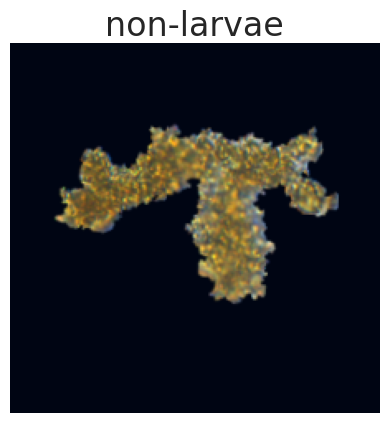

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Linear-13                  [-1, 128]       6,422,656
             ReLU-14                  [

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=2e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-5)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.7692 | Val Loss: 0.7301 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.8822 | Val Loss: 0.6707 | Train cohen_kappa_fn: 0.1727 | Val cohen_kappa_fn: 0.0608 | Train f1_fn: 0.8699 | Val f1_fn: 0.9028
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5874 | Val Loss: 0.6475 | Train cohen_kappa_fn: 0.0282 | Val cohen_kappa_fn: 0.1038 | Train f1_fn: 0.1583 | Val f1_fn: 0.4257
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5854 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.1506 | Val cohen_kappa_fn: 0.1275 | Train f1_fn: 0.5876 | Val f1_fn: 0.6667
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5337 | Val Loss: 0.6024 | Train cohen_kappa_fn: 0.2055 | Val cohen_kappa_fn: 0.1594 | Train f1_fn: 0.6888 | Val f1_fn: 0.7489
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5329 | Val Loss: 0.6379 | Train cohen_kappa_fn: 0.3786 | Val cohen_kappa_fn: 0.2161 | Train f1_fn: 0.8635 | Val f1_fn: 0.8317
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.4960 | Val Loss: 0.5486 | Train cohen_kappa_fn: 0.2426 | Val cohen_kappa_fn: 0.2251 | Train f1_fn: 0.6923 | Val f1_fn: 0.7652
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5135 | Val Loss: 0.5894 | Train cohen_kappa_fn: 0.4453 | Val cohen_kappa_fn: 0.2630 | Train f1_fn: 0.9009 | Val f1_fn: 0.9155
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.4275 | Val Loss: 0.5168 | Train cohen_kappa_fn: 0.3151 | Val cohen_kappa_fn: 0.2906 | Train f1_fn: 0.7877 | Val f1_fn: 0.8000
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4449 | Val Loss: 0.4984 | Train cohen_kappa_fn: 0.4430 | Val cohen_kappa_fn: 0.4602 | Train f1_fn: 0.8583 | Val f1_fn: 0.9053
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4010 | Val Loss: 0.4480 | Train cohen_kappa_fn: 0.4311 | Val cohen_kappa_fn: 0.4576 | Train f1_fn: 0.8526 | Val f1_fn: 0.9101
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3788 | Val Loss: 0.4359 | Train cohen_kappa_fn: 0.4915 | Val cohen_kappa_fn: 0.5183 | Train f1_fn: 0.8934 | Val f1_fn: 0.9328
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4025 | Val Loss: 0.3972 | Train cohen_kappa_fn: 0.5095 | Val cohen_kappa_fn: 0.5797 | Train f1_fn: 0.8901 | Val f1_fn: 0.9112
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3534 | Val Loss: 0.4896 | Train cohen_kappa_fn: 0.6811 | Val cohen_kappa_fn: 0.4701 | Train f1_fn: 0.9466 | Val f1_fn: 0.9000
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3615 | Val Loss: 0.4133 | Train cohen_kappa_fn: 0.4581 | Val cohen_kappa_fn: 0.3314 | Train f1_fn: 0.8557 | Val f1_fn: 0.7720
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3147 | Val Loss: 0.3773 | Train cohen_kappa_fn: 0.7168 | Val cohen_kappa_fn: 0.6591 | Train f1_fn: 0.9507 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3229 | Val Loss: 0.3614 | Train cohen_kappa_fn: 0.3830 | Val cohen_kappa_fn: 0.3557 | Train f1_fn: 0.8049 | Val f1_fn: 0.7848
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3667 | Val Loss: 0.3561 | Train cohen_kappa_fn: 0.5672 | Val cohen_kappa_fn: 0.5172 | Train f1_fn: 0.9040 | Val f1_fn: 0.8811
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3126 | Val Loss: 0.3593 | Train cohen_kappa_fn: 0.7134 | Val cohen_kappa_fn: 0.6867 | Train f1_fn: 0.9518 | Val f1_fn: 0.9520
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2722 | Val Loss: 0.3364 | Train cohen_kappa_fn: 0.6521 | Val cohen_kappa_fn: 0.6526 | Train f1_fn: 0.9305 | Val f1_fn: 0.9297
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2872 | Val Loss: 0.3404 | Train cohen_kappa_fn: 0.6635 | Val cohen_kappa_fn: 0.6170 | Train f1_fn: 0.9319 | Val f1_fn: 0.9191
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2714 | Val Loss: 0.3561 | Train cohen_kappa_fn: 0.6507 | Val cohen_kappa_fn: 0.5348 | Train f1_fn: 0.9276 | Val f1_fn: 0.8934
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2585 | Val Loss: 0.3485 | Train cohen_kappa_fn: 0.5955 | Val cohen_kappa_fn: 0.5003 | Train f1_fn: 0.9094 | Val f1_fn: 0.8798
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2735 | Val Loss: 0.3758 | Train cohen_kappa_fn: 0.7671 | Val cohen_kappa_fn: 0.6963 | Train f1_fn: 0.9608 | Val f1_fn: 0.9540
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2531 | Val Loss: 0.3607 | Train cohen_kappa_fn: 0.7378 | Val cohen_kappa_fn: 0.7206 | Train f1_fn: 0.9583 | Val f1_fn: 0.9576
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


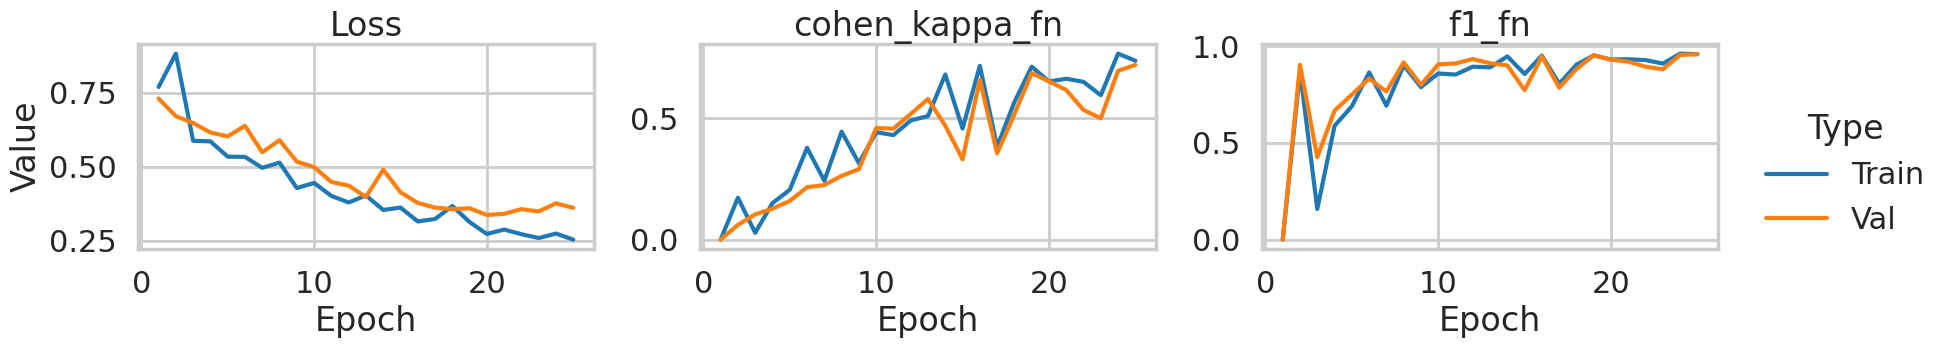

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3158 | Test cohen_kappa_fn: 0.6470 | Test f1_fn: 0.9333


#### Visualization

In [14]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

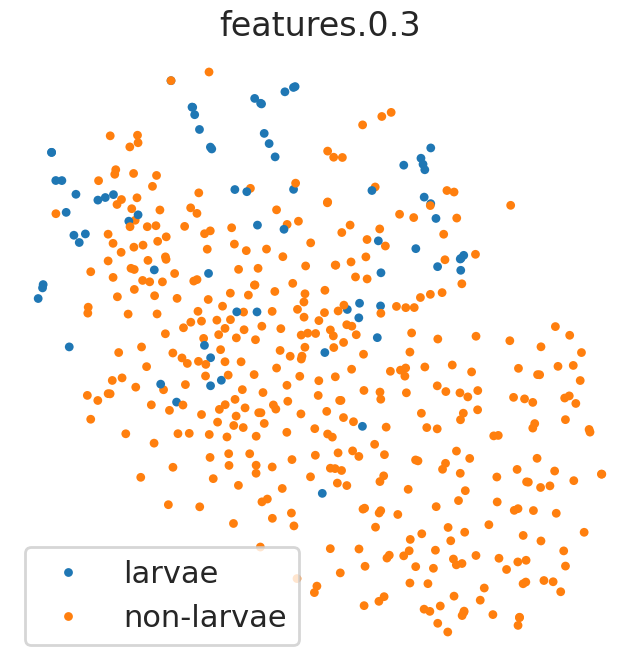

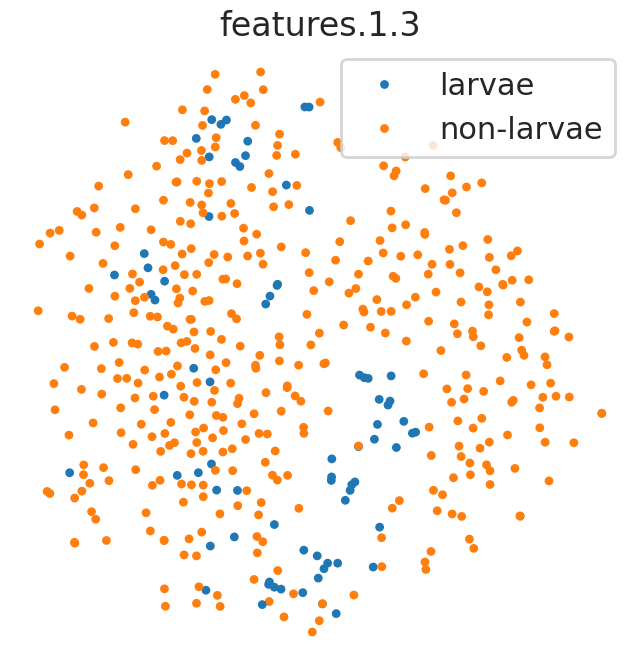

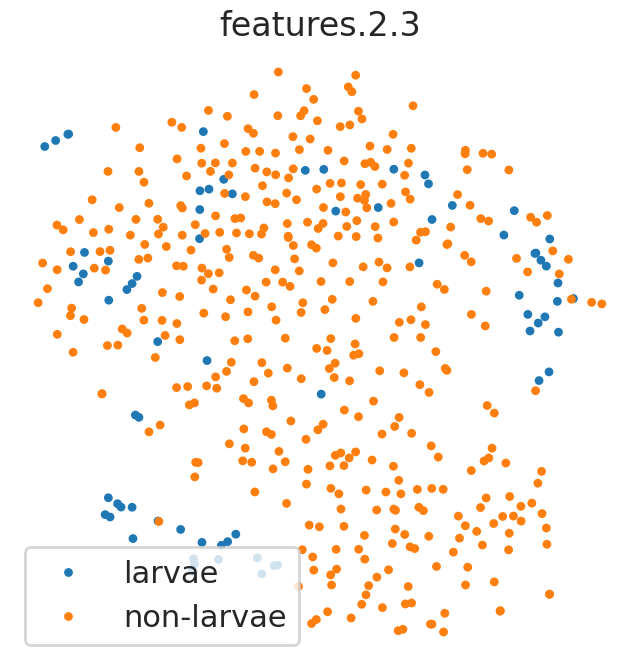

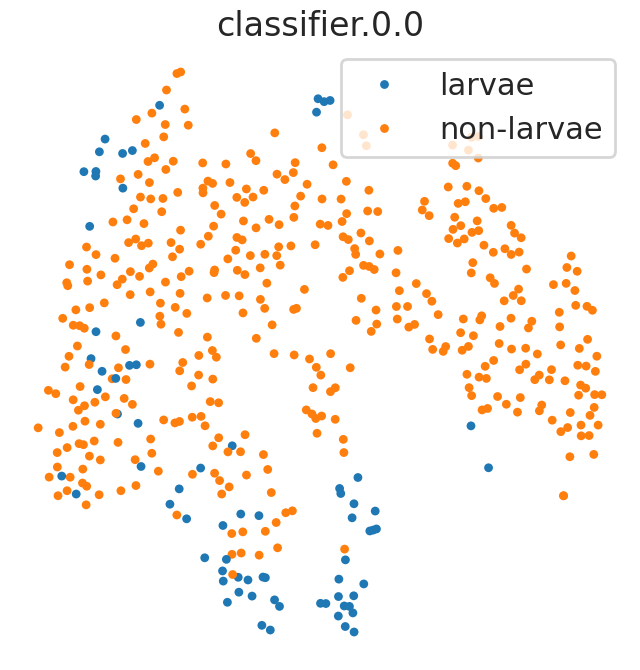

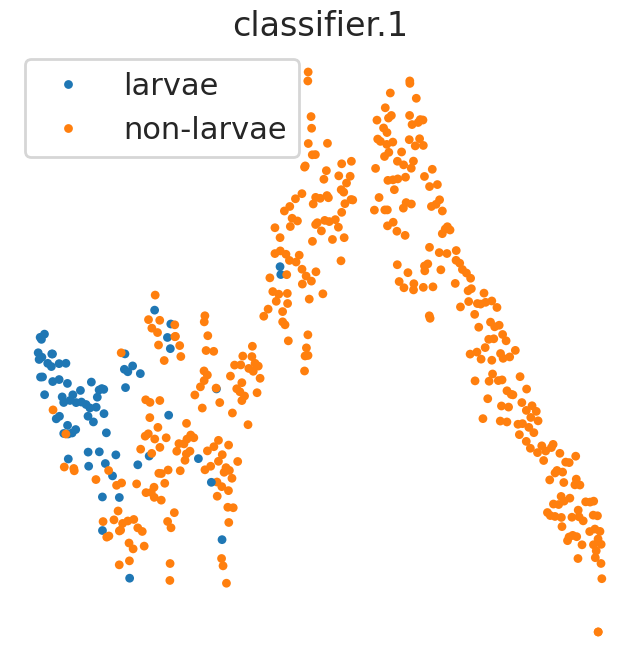

In [15]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


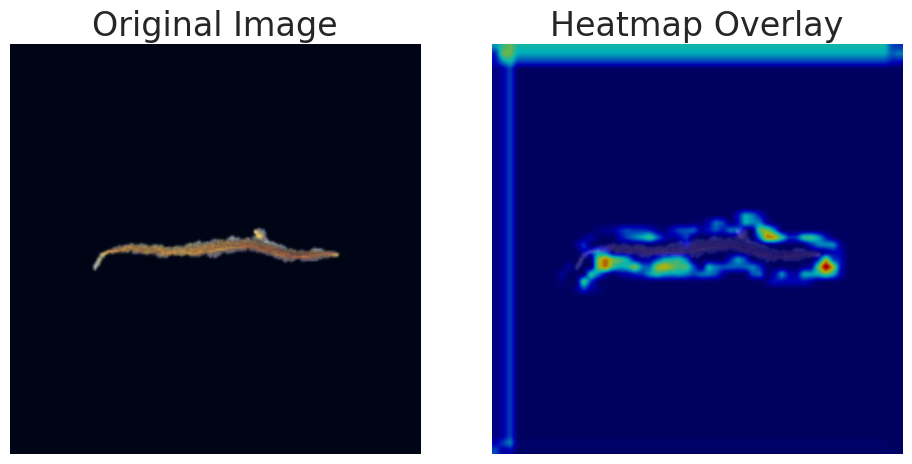

  Generating heatmap for Larvae...
  Predicted label is Larvae!


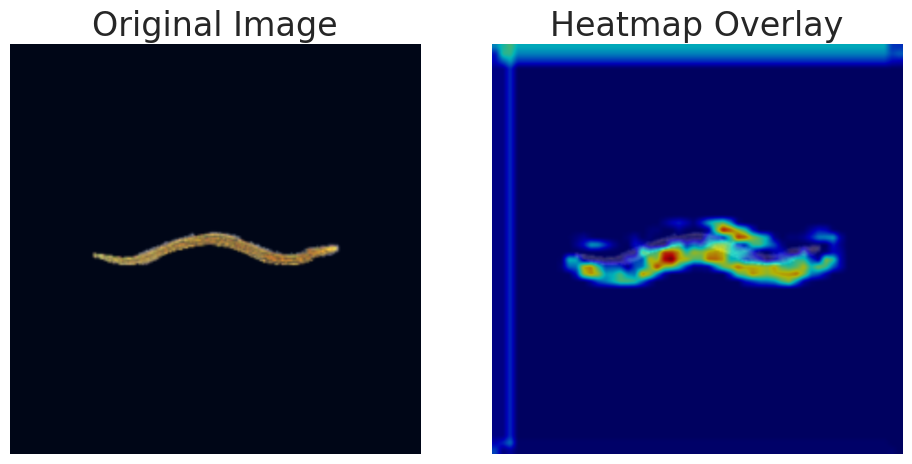

In [16]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [17]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [18]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=2e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-5)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [19]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.7531 | Val Loss: 0.6916 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6903 | Val Loss: 0.6748 | Train cohen_kappa_fn: 0.2004 | Val cohen_kappa_fn: 0.2418 | Train f1_fn: 0.7903 | Val f1_fn: 0.8505
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6223 | Val Loss: 0.6299 | Train cohen_kappa_fn: 0.0992 | Val cohen_kappa_fn: 0.1373 | Train f1_fn: 0.4242 | Val f1_fn: 0.5191
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5714 | Val Loss: 0.5753 | Train cohen_kappa_fn: 0.2386 | Val cohen_kappa_fn: 0.3318 | Train f1_fn: 0.7391 | Val f1_fn: 0.8577
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5006 | Val Loss: 0.5055 | Train cohen_kappa_fn: 0.1634 | Val cohen_kappa_fn: 0.2689 | Train f1_fn: 0.5741 | Val f1_fn: 0.7095
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4926 | Val Loss: 0.4764 | Train cohen_kappa_fn: 0.3852 | Val cohen_kappa_fn: 0.3797 | Train f1_fn: 0.8388 | Val f1_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4357 | Val Loss: 0.4414 | Train cohen_kappa_fn: 0.4869 | Val cohen_kappa_fn: 0.4389 | Train f1_fn: 0.8790 | Val f1_fn: 0.8765
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4425 | Val Loss: 0.5280 | Train cohen_kappa_fn: 0.1398 | Val cohen_kappa_fn: 0.1430 | Train f1_fn: 0.5192 | Val f1_fn: 0.5165
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.4307 | Val Loss: 0.4258 | Train cohen_kappa_fn: 0.6765 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.9477 | Val f1_fn: 0.9362
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3672 | Val Loss: 0.3657 | Train cohen_kappa_fn: 0.3473 | Val cohen_kappa_fn: 0.3849 | Train f1_fn: 0.7842 | Val f1_fn: 0.8096
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3114 | Val Loss: 0.4025 | Train cohen_kappa_fn: 0.7422 | Val cohen_kappa_fn: 0.7002 | Train f1_fn: 0.9599 | Val f1_fn: 0.9604
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.3290 | Val Loss: 0.5143 | Train cohen_kappa_fn: 0.1627 | Val cohen_kappa_fn: 0.1905 | Train f1_fn: 0.5577 | Val f1_fn: 0.6010
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3094 | Val Loss: 0.4061 | Train cohen_kappa_fn: 0.7672 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9654 | Val f1_fn: 0.9587
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2523 | Val Loss: 0.2808 | Train cohen_kappa_fn: 0.5082 | Val cohen_kappa_fn: 0.5458 | Train f1_fn: 0.8738 | Val f1_fn: 0.8925
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2748 | Val Loss: 0.3735 | Train cohen_kappa_fn: 0.8049 | Val cohen_kappa_fn: 0.7266 | Train f1_fn: 0.9696 | Val f1_fn: 0.9619
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2321 | Val Loss: 0.4394 | Train cohen_kappa_fn: 0.8124 | Val cohen_kappa_fn: 0.7057 | Train f1_fn: 0.9720 | Val f1_fn: 0.9603
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2522 | Val Loss: 0.4659 | Train cohen_kappa_fn: 0.8198 | Val cohen_kappa_fn: 0.6561 | Train f1_fn: 0.9736 | Val f1_fn: 0.9551
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2028 | Val Loss: 0.2510 | Train cohen_kappa_fn: 0.6098 | Val cohen_kappa_fn: 0.6479 | Train f1_fn: 0.9126 | Val f1_fn: 0.9300
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2086 | Val Loss: 0.4649 | Train cohen_kappa_fn: 0.8529 | Val cohen_kappa_fn: 0.6667 | Train f1_fn: 0.9779 | Val f1_fn: 0.9570
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1945 | Val Loss: 0.2527 | Train cohen_kappa_fn: 0.6477 | Val cohen_kappa_fn: 0.6284 | Train f1_fn: 0.9247 | Val f1_fn: 0.9261
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1970 | Val Loss: 0.4689 | Train cohen_kappa_fn: 0.8618 | Val cohen_kappa_fn: 0.7002 | Train f1_fn: 0.9794 | Val f1_fn: 0.9604
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1975 | Val Loss: 0.2488 | Train cohen_kappa_fn: 0.7687 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9579 | Val f1_fn: 0.9625
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1595 | Val Loss: 0.2773 | Train cohen_kappa_fn: 0.8220 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9698 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1400 | Val Loss: 0.2883 | Train cohen_kappa_fn: 0.8499 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9752 | Val f1_fn: 0.9647
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1591 | Val Loss: 0.3241 | Train cohen_kappa_fn: 0.8327 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9722 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1514 | Val Loss: 0.3207 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9775 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1552 | Val Loss: 0.3496 | Train cohen_kappa_fn: 0.8722 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9790 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


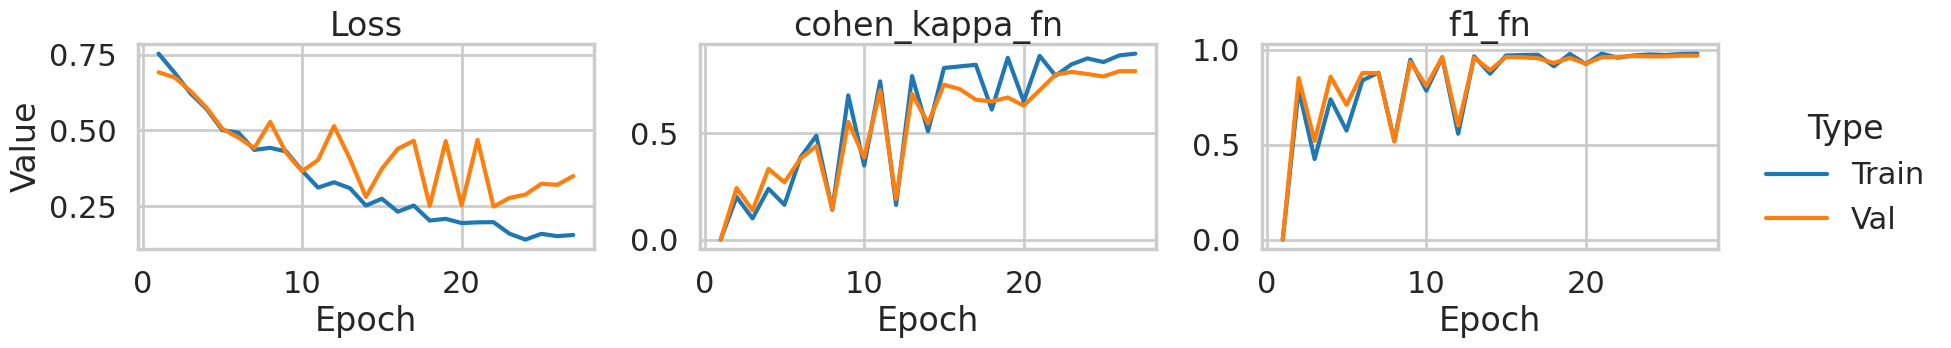

In [20]:
trainer_cnn_1.plot_epochs()

In [21]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2153 | Test cohen_kappa_fn: 0.7923 | Test f1_fn: 0.9680


#### Visualization

In [22]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

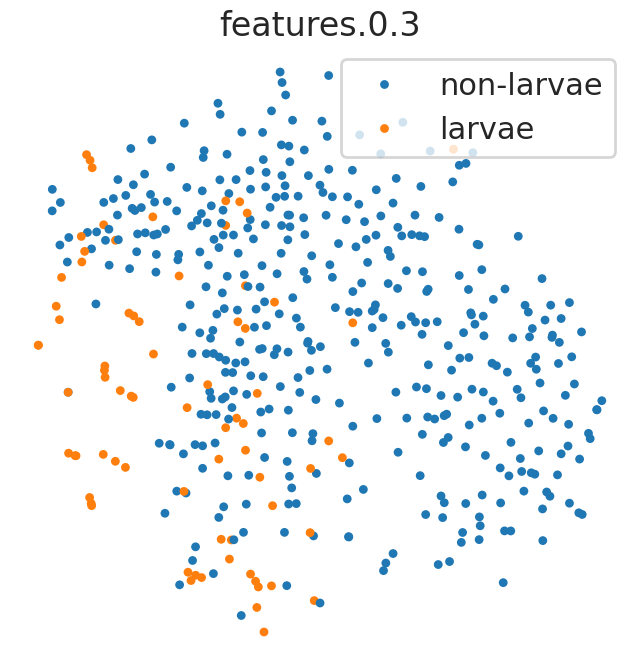

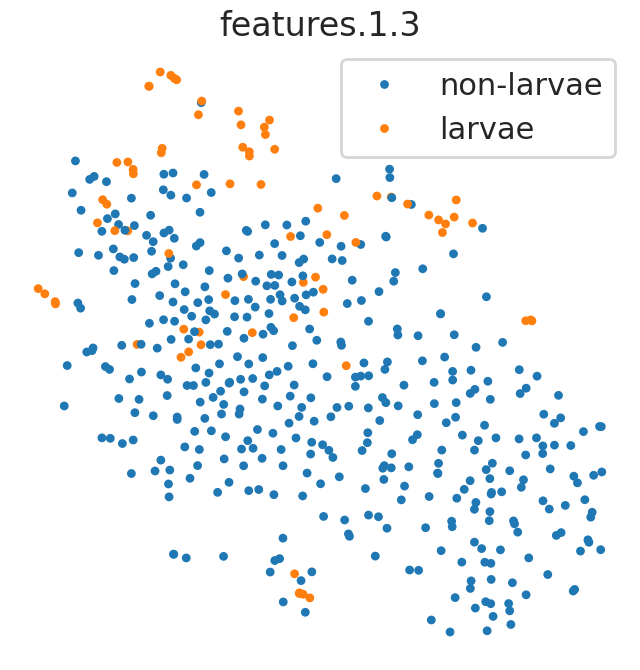

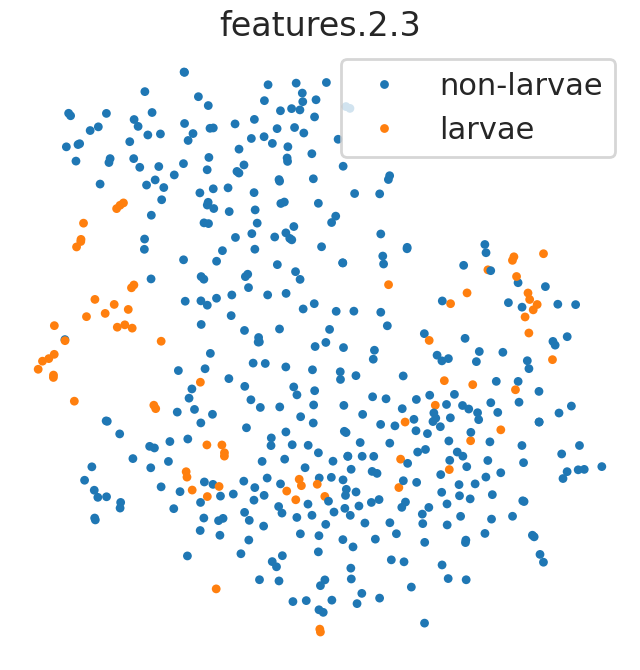

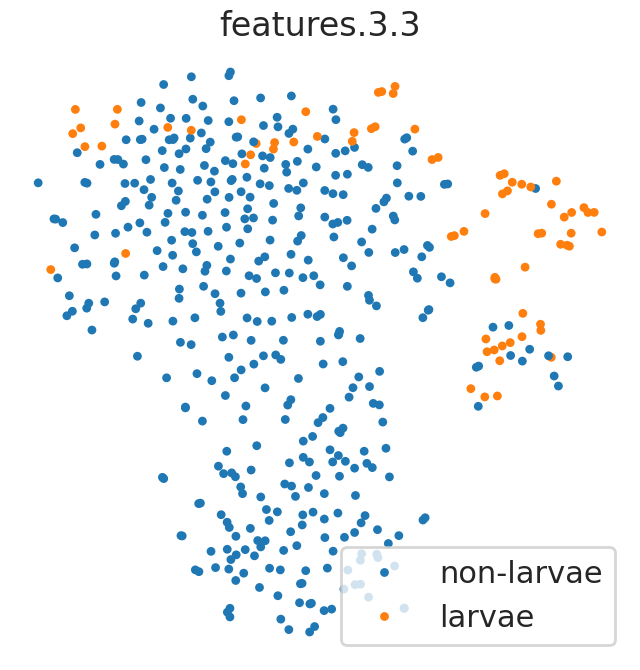

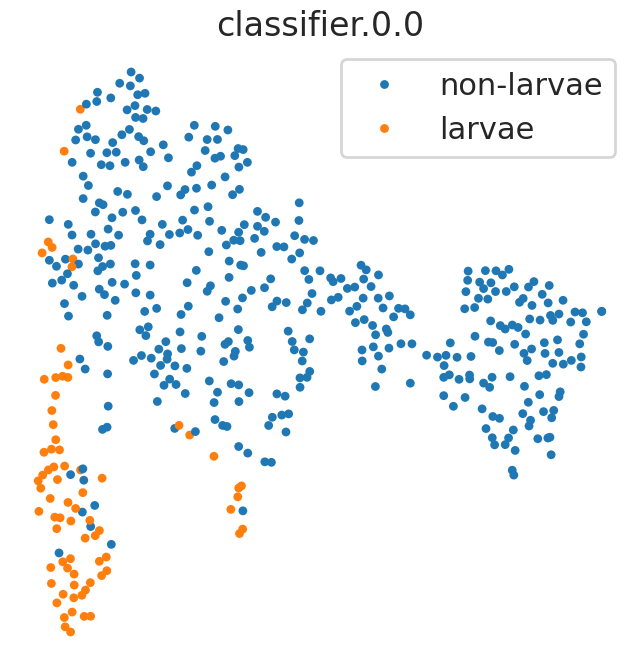

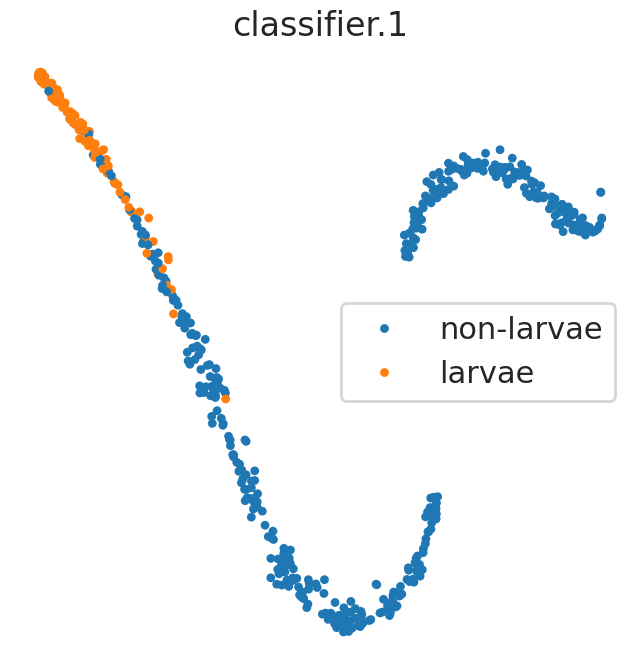

In [23]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


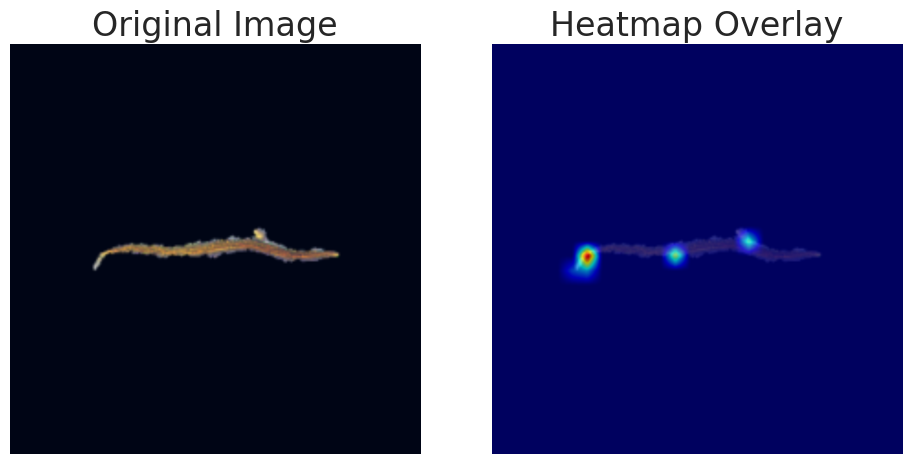

  Generating heatmap for Larvae...
  Predicted label is Larvae!


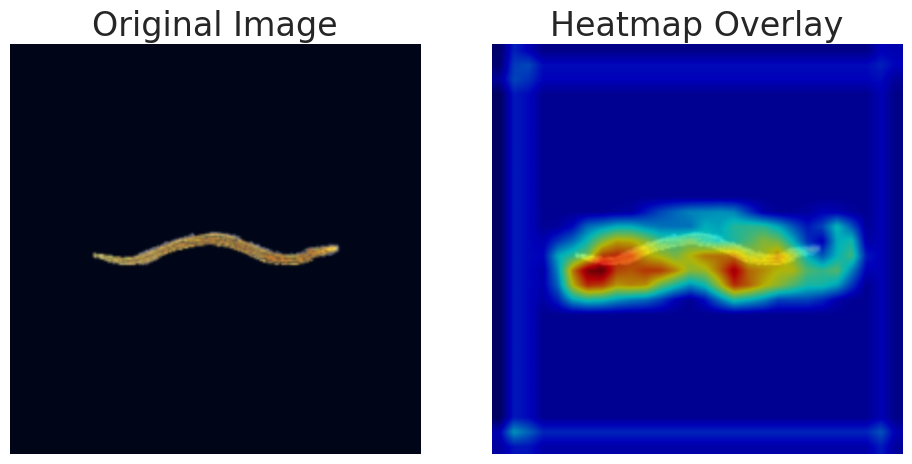

In [24]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [25]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [26]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=2e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-5)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [27]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.7833 | Val Loss: 0.6946 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6465 | Val Loss: 0.6702 | Train cohen_kappa_fn: 0.0798 | Val cohen_kappa_fn: 0.0657 | Train f1_fn: 0.9202 | Val f1_fn: 0.9184
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6056 | Val Loss: 0.6299 | Train cohen_kappa_fn: 0.1343 | Val cohen_kappa_fn: 0.1351 | Train f1_fn: 0.5077 | Val f1_fn: 0.5000
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5286 | Val Loss: 0.5501 | Train cohen_kappa_fn: 0.4008 | Val cohen_kappa_fn: 0.4328 | Train f1_fn: 0.9046 | Val f1_fn: 0.8872
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4511 | Val Loss: 0.4759 | Train cohen_kappa_fn: 0.5089 | Val cohen_kappa_fn: 0.5559 | Train f1_fn: 0.9333 | Val f1_fn: 0.9271
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3831 | Val Loss: 0.3467 | Train cohen_kappa_fn: 0.6837 | Val cohen_kappa_fn: 0.6431 | Train f1_fn: 0.9493 | Val f1_fn: 0.9302
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3223 | Val Loss: 0.2859 | Train cohen_kappa_fn: 0.7627 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9610 | Val f1_fn: 0.9446
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2715 | Val Loss: 0.3023 | Train cohen_kappa_fn: 0.7158 | Val cohen_kappa_fn: 0.7508 | Train f1_fn: 0.9590 | Val f1_fn: 0.9634
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2392 | Val Loss: 0.3375 | Train cohen_kappa_fn: 0.4163 | Val cohen_kappa_fn: 0.4058 | Train f1_fn: 0.8257 | Val f1_fn: 0.8225
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2134 | Val Loss: 0.4627 | Train cohen_kappa_fn: 0.7291 | Val cohen_kappa_fn: 0.7274 | Train f1_fn: 0.9639 | Val f1_fn: 0.9640
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2190 | Val Loss: 0.2886 | Train cohen_kappa_fn: 0.8047 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9687 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1761 | Val Loss: 0.2083 | Train cohen_kappa_fn: 0.7755 | Val cohen_kappa_fn: 0.7681 | Train f1_fn: 0.9605 | Val f1_fn: 0.9605
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1679 | Val Loss: 0.4325 | Train cohen_kappa_fn: 0.7971 | Val cohen_kappa_fn: 0.7746 | Train f1_fn: 0.9716 | Val f1_fn: 0.9693
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1518 | Val Loss: 0.8743 | Train cohen_kappa_fn: 0.6158 | Val cohen_kappa_fn: 0.5500 | Train f1_fn: 0.9546 | Val f1_fn: 0.9490
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1612 | Val Loss: 0.2443 | Train cohen_kappa_fn: 0.7084 | Val cohen_kappa_fn: 0.6828 | Train f1_fn: 0.9414 | Val f1_fn: 0.9380
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1431 | Val Loss: 1.1159 | Train cohen_kappa_fn: 0.4856 | Val cohen_kappa_fn: 0.3476 | Train f1_fn: 0.9439 | Val f1_fn: 0.9343
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1294 | Val Loss: 1.0776 | Train cohen_kappa_fn: 0.6234 | Val cohen_kappa_fn: 0.3962 | Train f1_fn: 0.9553 | Val f1_fn: 0.9375
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


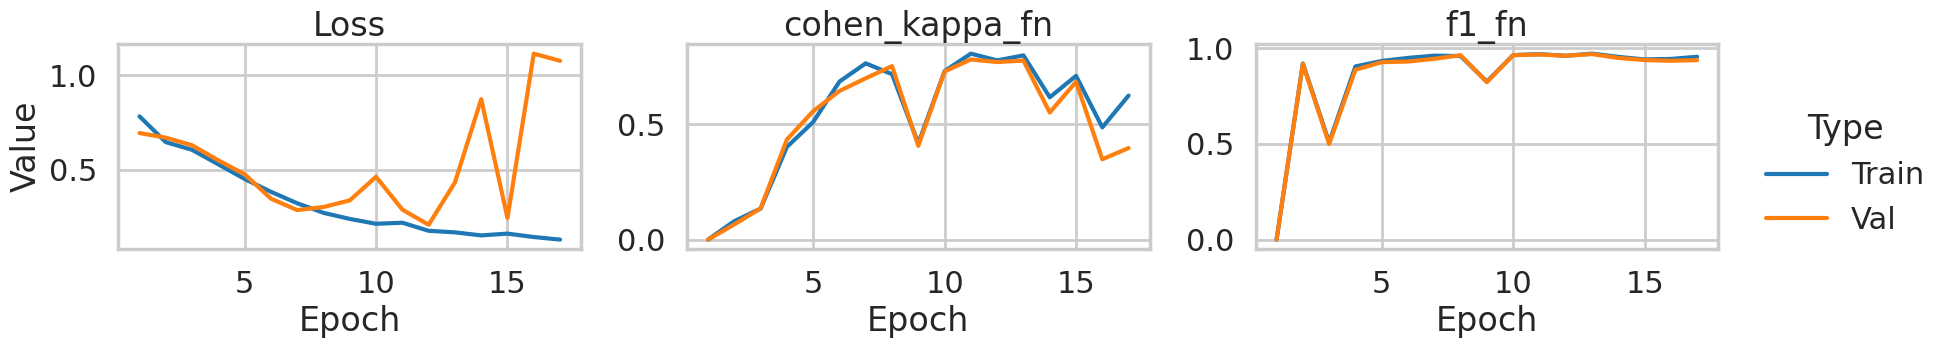

In [28]:
trainer_cnn_2.plot_epochs()

In [29]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1818 | Test cohen_kappa_fn: 0.7776 | Test f1_fn: 0.9624


#### Visualization

In [30]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

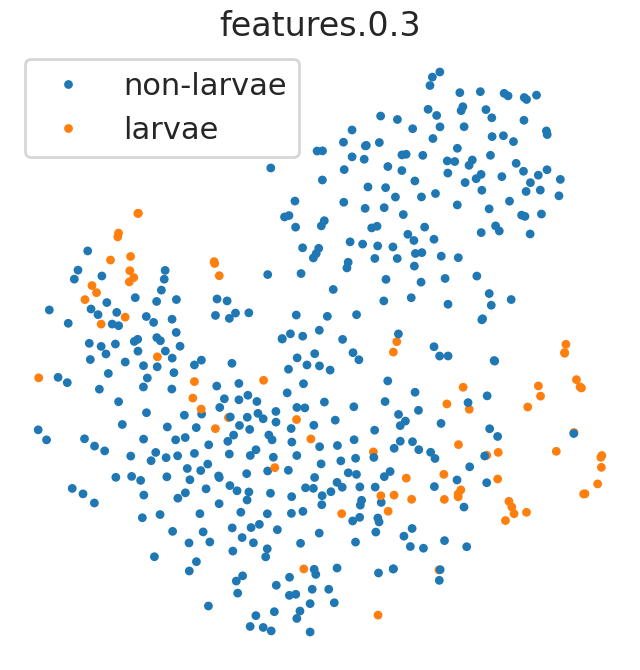

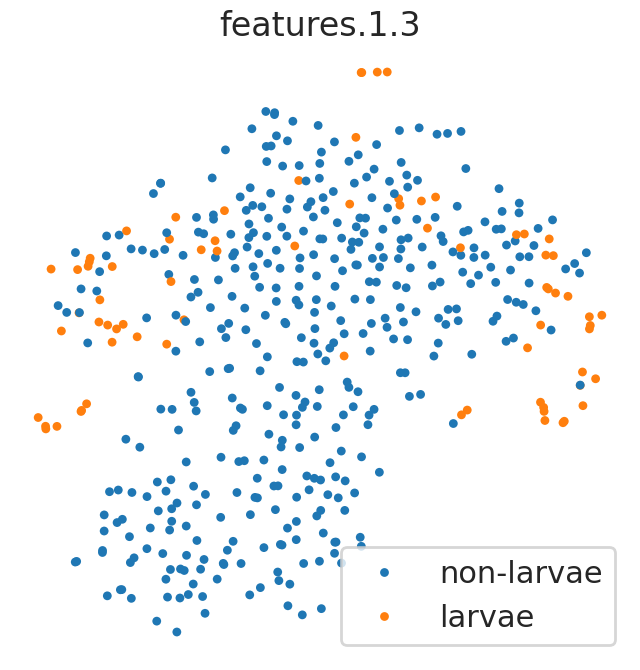

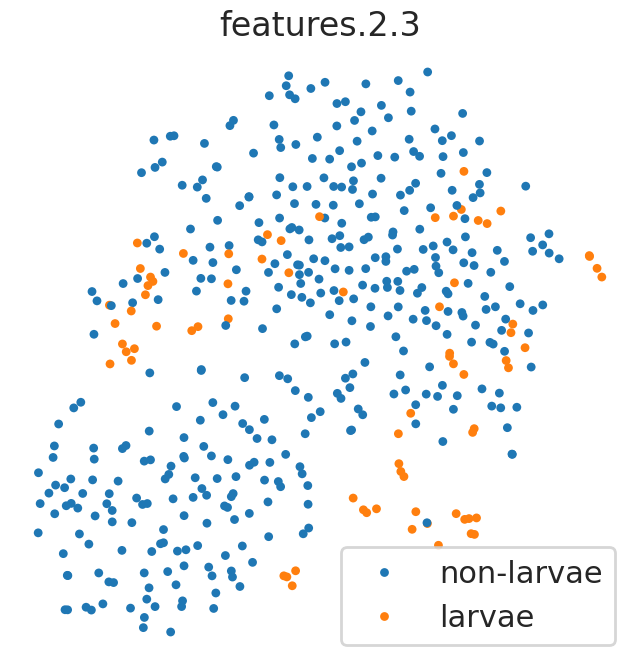

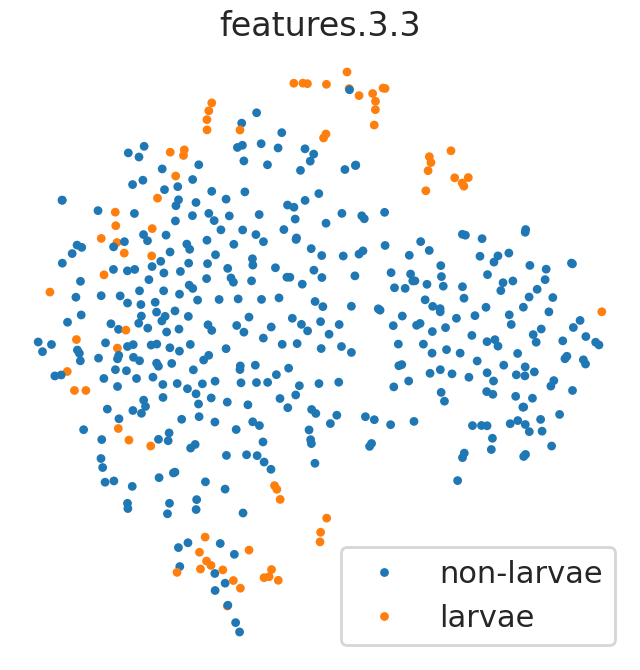

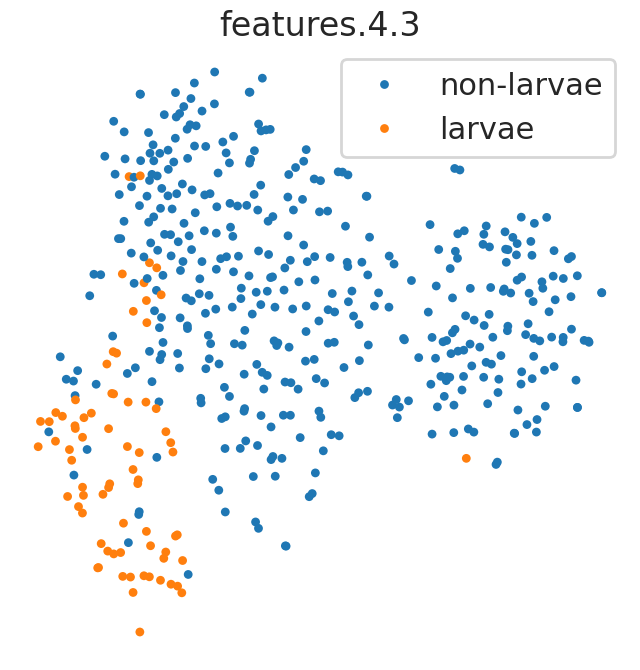

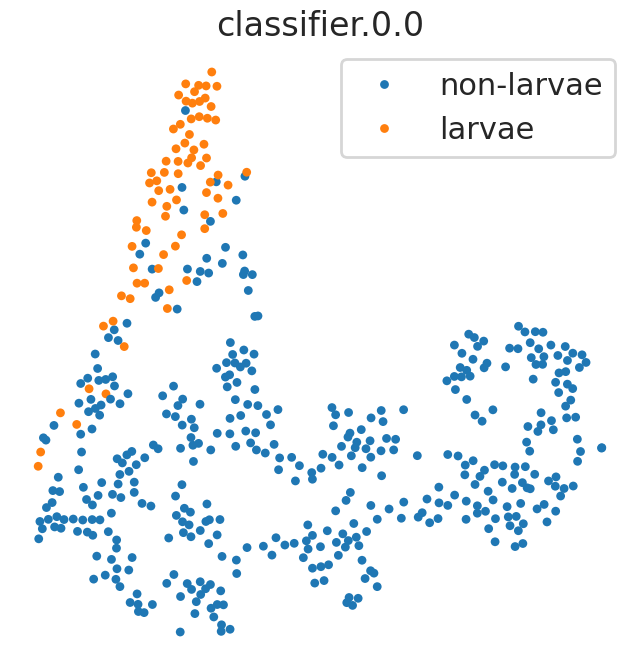

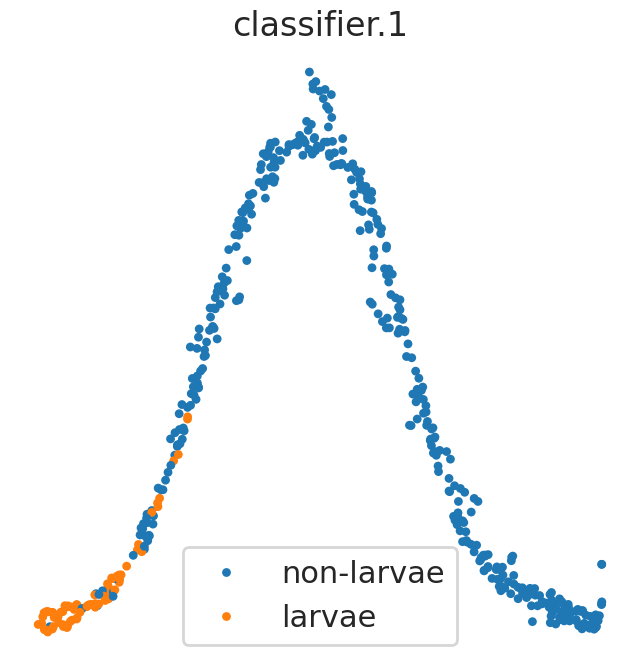

In [31]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


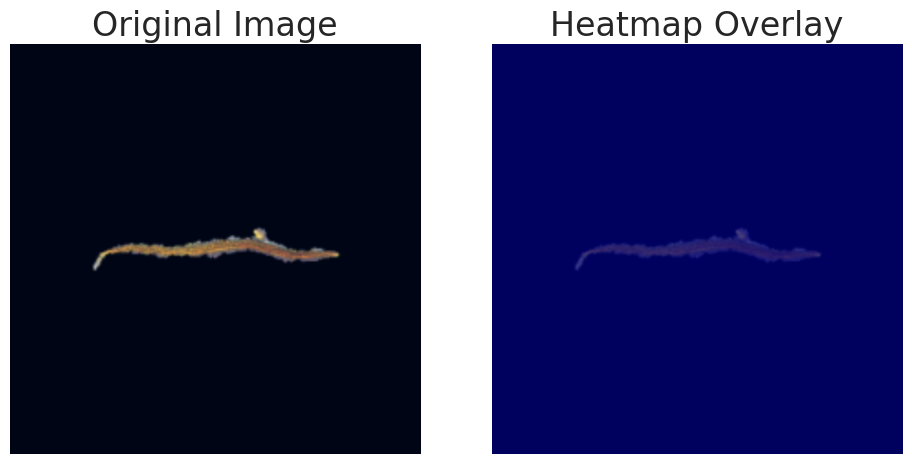

  Generating heatmap for Larvae...
  Predicted label is Larvae!


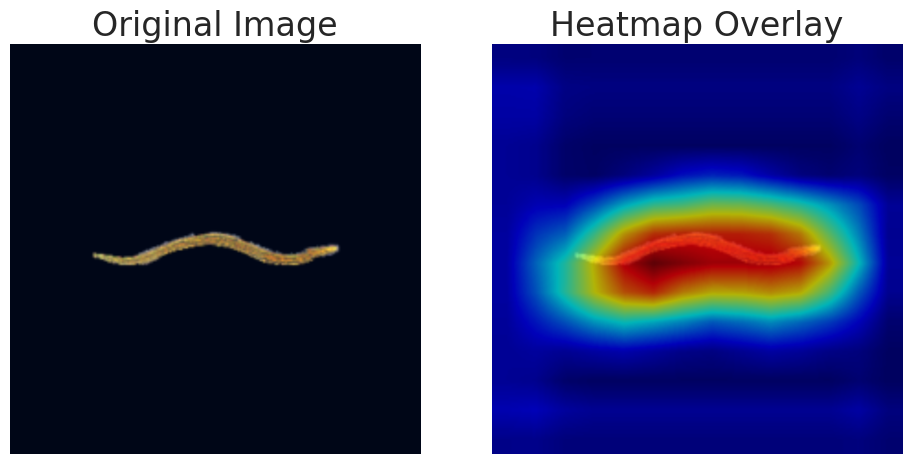

In [32]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [33]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,128,256,512],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1, 128,

In [34]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=2e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-5)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [35]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6510 | Val Loss: 0.6770 | Train cohen_kappa_fn: 0.0621 | Val cohen_kappa_fn: 0.0772 | Train f1_fn: 0.3100 | Val f1_fn: 0.3486
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5266 | Val Loss: 0.6034 | Train cohen_kappa_fn: 0.4381 | Val cohen_kappa_fn: 0.5933 | Train f1_fn: 0.9390 | Val f1_fn: 0.9481
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.3869 | Val Loss: 0.4677 | Train cohen_kappa_fn: 0.5280 | Val cohen_kappa_fn: 0.6561 | Train f1_fn: 0.9456 | Val f1_fn: 0.9551
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2856 | Val Loss: 0.5706 | Train cohen_kappa_fn: 0.3750 | Val cohen_kappa_fn: 0.5189 | Train f1_fn: 0.9360 | Val f1_fn: 0.9455
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.2639 | Val Loss: 0.2736 | Train cohen_kappa_fn: 0.8132 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9711 | Val f1_fn: 0.9551
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2186 | Val Loss: 0.2784 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.7245 | Train f1_fn: 0.9733 | Val f1_fn: 0.9552
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1817 | Val Loss: 0.2572 | Train cohen_kappa_fn: 0.8080 | Val cohen_kappa_fn: 0.6693 | Train f1_fn: 0.9676 | Val f1_fn: 0.9387
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1559 | Val Loss: 0.2472 | Train cohen_kappa_fn: 0.8485 | Val cohen_kappa_fn: 0.8001 | Train f1_fn: 0.9771 | Val f1_fn: 0.9685
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1481 | Val Loss: 0.4030 | Train cohen_kappa_fn: 0.7385 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9662 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1318 | Val Loss: 0.7223 | Train cohen_kappa_fn: 0.6082 | Val cohen_kappa_fn: 0.6494 | Train f1_fn: 0.9539 | Val f1_fn: 0.9553
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1126 | Val Loss: 0.5412 | Train cohen_kappa_fn: 0.7534 | Val cohen_kappa_fn: 0.7787 | Train f1_fn: 0.9676 | Val f1_fn: 0.9691
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1187 | Val Loss: 0.1731 | Train cohen_kappa_fn: 0.8349 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9712 | Val f1_fn: 0.9606
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1158 | Val Loss: 0.1712 | Train cohen_kappa_fn: 0.8610 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9757 | Val f1_fn: 0.9641
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1008 | Val Loss: 0.4440 | Train cohen_kappa_fn: 0.8883 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9839 | Val f1_fn: 0.9709
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.0752 | Val Loss: 0.5953 | Train cohen_kappa_fn: 0.8930 | Val cohen_kappa_fn: 0.7526 | Train f1_fn: 0.9846 | Val f1_fn: 0.9655
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0736 | Val Loss: 1.7743 | Train cohen_kappa_fn: 0.3015 | Val cohen_kappa_fn: 0.2432 | Train f1_fn: 0.9323 | Val f1_fn: 0.9278
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.0770 | Val Loss: 0.2550 | Train cohen_kappa_fn: 0.6339 | Val cohen_kappa_fn: 0.6246 | Train f1_fn: 0.9183 | Val f1_fn: 0.9160
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.0876 | Val Loss: 0.2218 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.7901 | Train f1_fn: 0.9880 | Val f1_fn: 0.9665
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


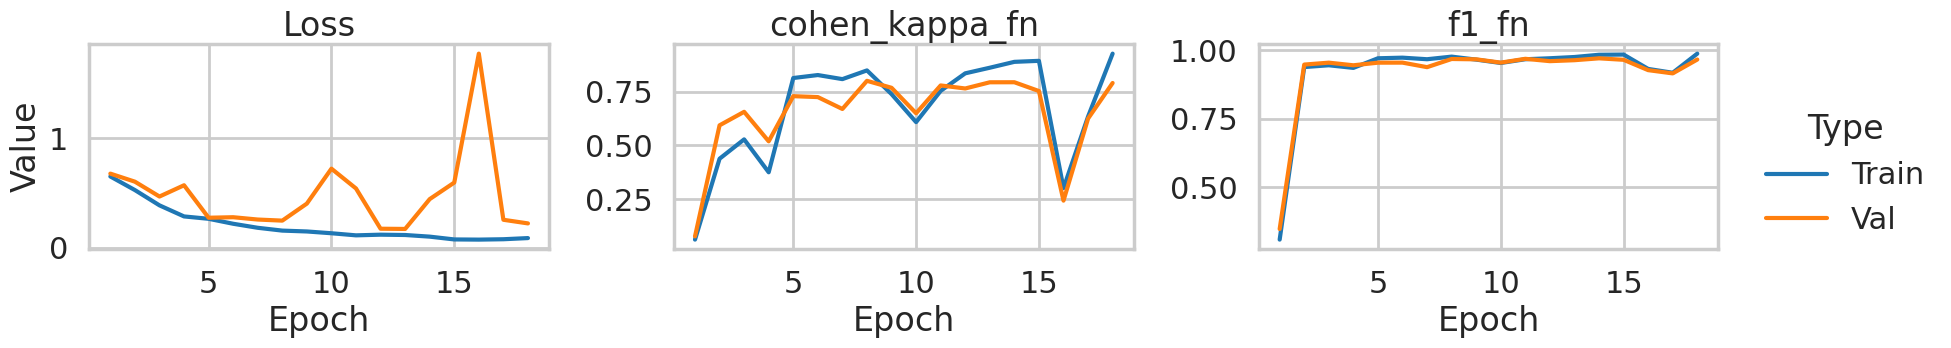

In [36]:
trainer_cnn_3.plot_epochs()

In [37]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1173 | Test cohen_kappa_fn: 0.8517 | Test f1_fn: 0.9749


#### Visualization

In [38]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

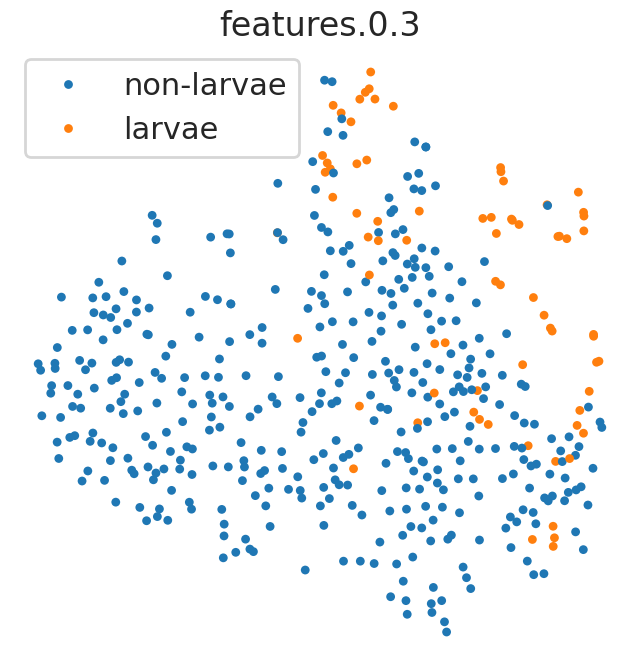

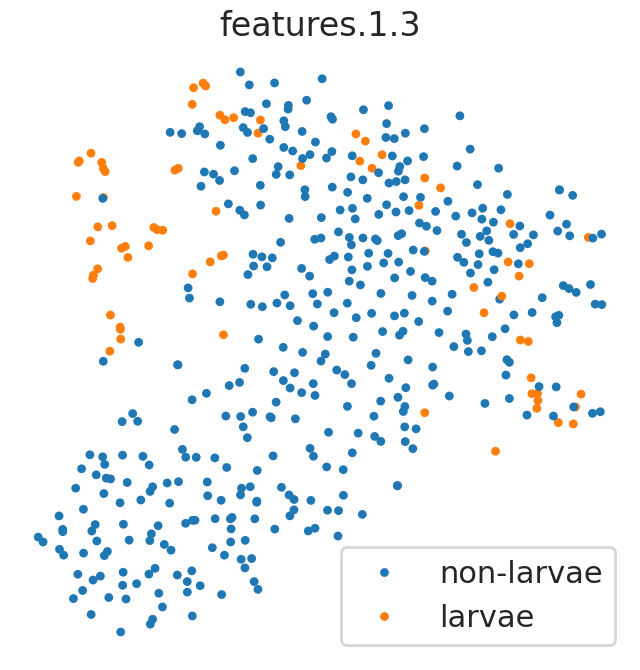

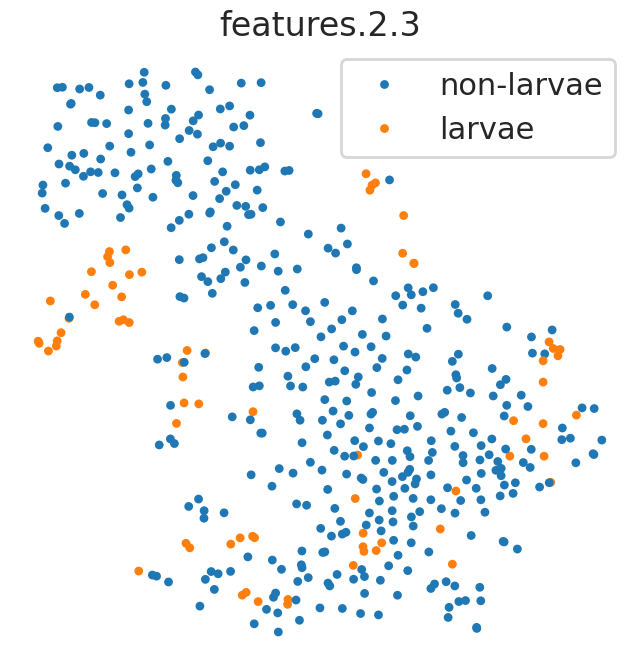

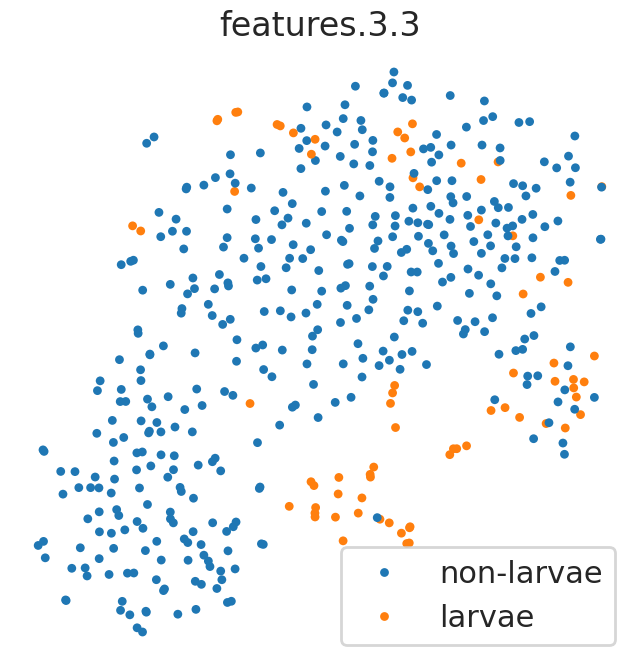

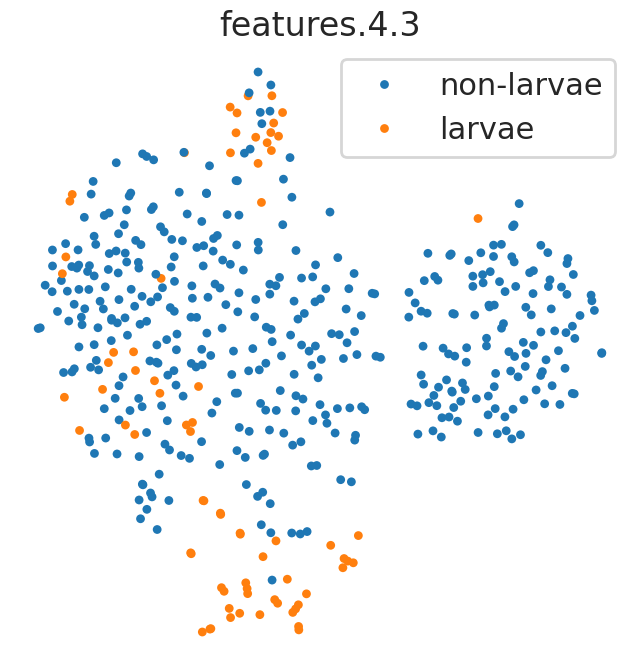

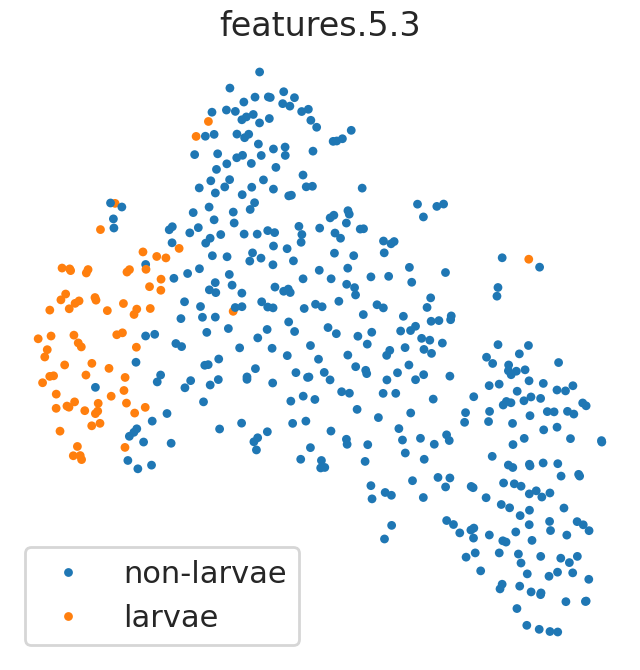

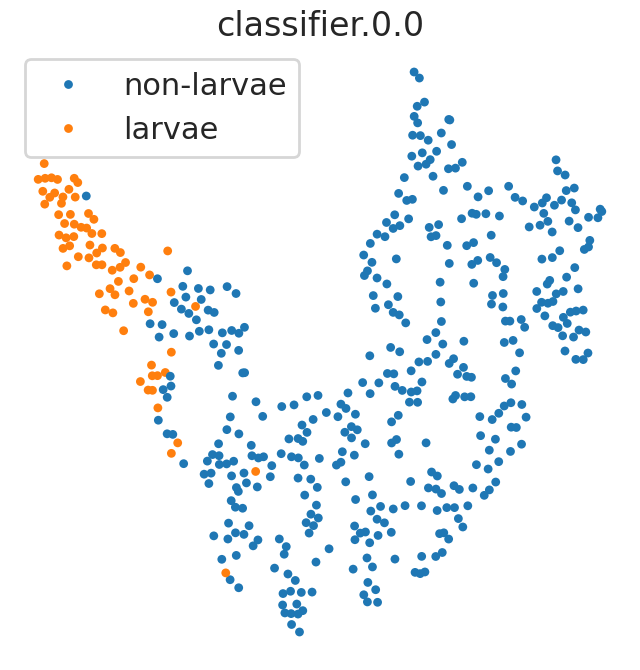

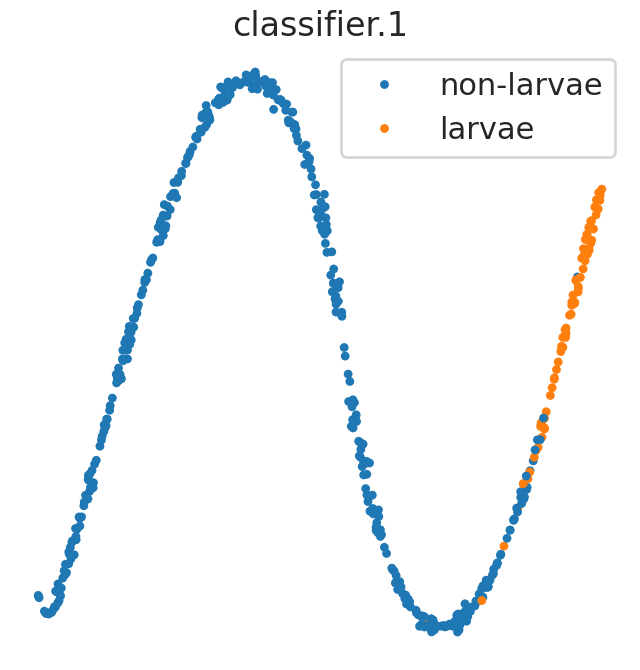

In [39]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


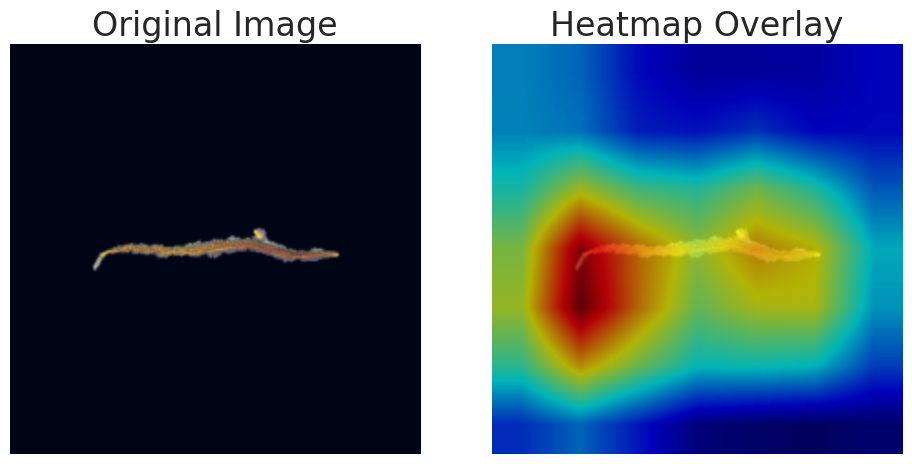

  Generating heatmap for Larvae...
  Predicted label is Larvae!


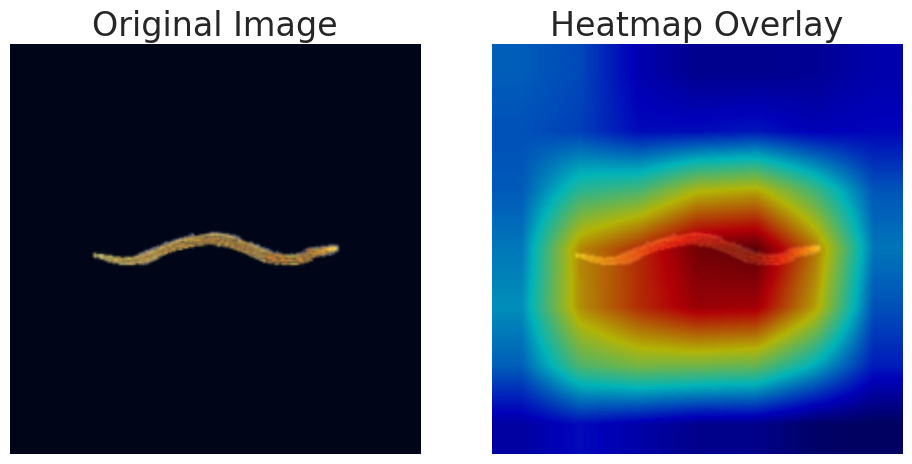

In [40]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [41]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [42]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=2e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-5)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [43]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6919 | Val Loss: 0.6992 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6361 | Val Loss: 0.6811 | Train cohen_kappa_fn: 0.0146 | Val cohen_kappa_fn: 0.0168 | Train f1_fn: 0.0878 | Val f1_fn: 0.0986
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5677 | Val Loss: 0.6096 | Train cohen_kappa_fn: 0.1645 | Val cohen_kappa_fn: 0.1313 | Train f1_fn: 0.5810 | Val f1_fn: 0.5069
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4639 | Val Loss: 0.5201 | Train cohen_kappa_fn: 0.2468 | Val cohen_kappa_fn: 0.2198 | Train f1_fn: 0.7034 | Val f1_fn: 0.6432
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4065 | Val Loss: 0.4502 | Train cohen_kappa_fn: 0.3375 | Val cohen_kappa_fn: 0.2518 | Train f1_fn: 0.7792 | Val f1_fn: 0.6829
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3698 | Val Loss: 0.3619 | Train cohen_kappa_fn: 0.5547 | Val cohen_kappa_fn: 0.3846 | Train f1_fn: 0.8996 | Val f1_fn: 0.8000
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3347 | Val Loss: 0.4764 | Train cohen_kappa_fn: 0.3704 | Val cohen_kappa_fn: 0.2048 | Train f1_fn: 0.7964 | Val f1_fn: 0.6224
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.2752 | Val Loss: 0.5957 | Train cohen_kappa_fn: 0.2782 | Val cohen_kappa_fn: 0.1637 | Train f1_fn: 0.7143 | Val f1_fn: 0.5561
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2456 | Val Loss: 0.3085 | Train cohen_kappa_fn: 0.6536 | Val cohen_kappa_fn: 0.5399 | Train f1_fn: 0.9284 | Val f1_fn: 0.8902
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.2086 | Val Loss: 0.2964 | Train cohen_kappa_fn: 0.6091 | Val cohen_kappa_fn: 0.5010 | Train f1_fn: 0.9116 | Val f1_fn: 0.8714
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1856 | Val Loss: 0.2330 | Train cohen_kappa_fn: 0.7147 | Val cohen_kappa_fn: 0.6571 | Train f1_fn: 0.9440 | Val f1_fn: 0.9294
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1899 | Val Loss: 0.4096 | Train cohen_kappa_fn: 0.3783 | Val cohen_kappa_fn: 0.3650 | Train f1_fn: 0.7979 | Val f1_fn: 0.7965
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1738 | Val Loss: 0.2161 | Train cohen_kappa_fn: 0.6694 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9305 | Val f1_fn: 0.9315
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1517 | Val Loss: 0.1964 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9618 | Val f1_fn: 0.9682
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1814 | Val Loss: 0.2170 | Train cohen_kappa_fn: 0.6828 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9338 | Val f1_fn: 0.9354
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1273 | Val Loss: 0.4310 | Train cohen_kappa_fn: 0.8030 | Val cohen_kappa_fn: 0.7481 | Train f1_fn: 0.9723 | Val f1_fn: 0.9656
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1611 | Val Loss: 0.2171 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9760 | Val f1_fn: 0.9645
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1285 | Val Loss: 0.2599 | Train cohen_kappa_fn: 0.8798 | Val cohen_kappa_fn: 0.8072 | Train f1_fn: 0.9806 | Val f1_fn: 0.9705
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1192 | Val Loss: 0.3399 | Train cohen_kappa_fn: 0.8845 | Val cohen_kappa_fn: 0.7677 | Train f1_fn: 0.9831 | Val f1_fn: 0.9673
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


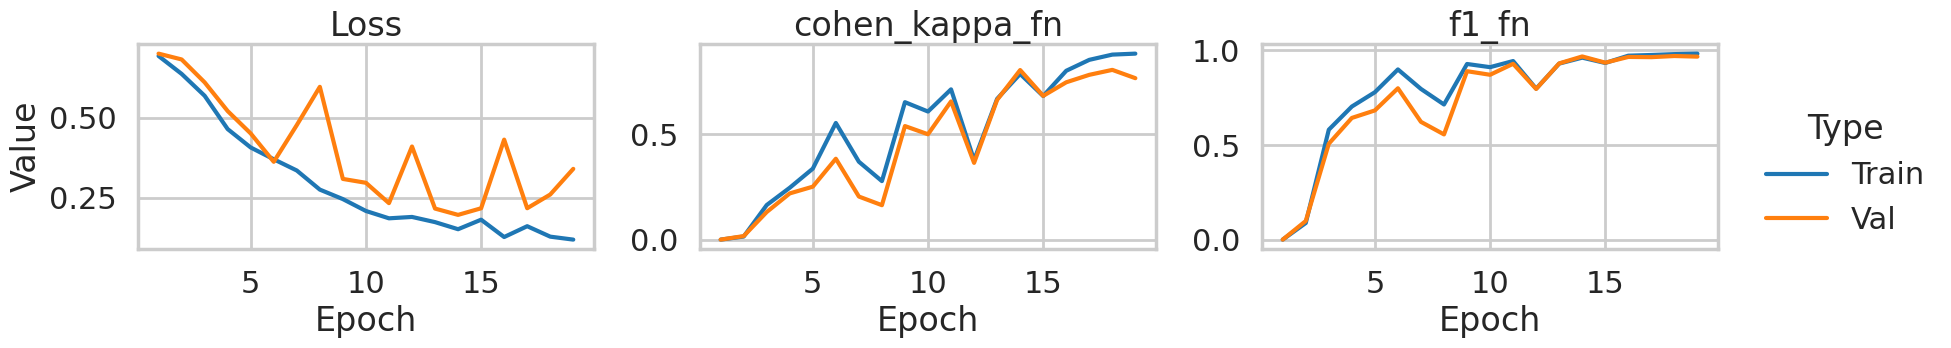

In [44]:
trainer_cnn_4.plot_epochs()

In [45]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1716 | Test cohen_kappa_fn: 0.8202 | Test f1_fn: 0.9700


#### Visualization

In [46]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

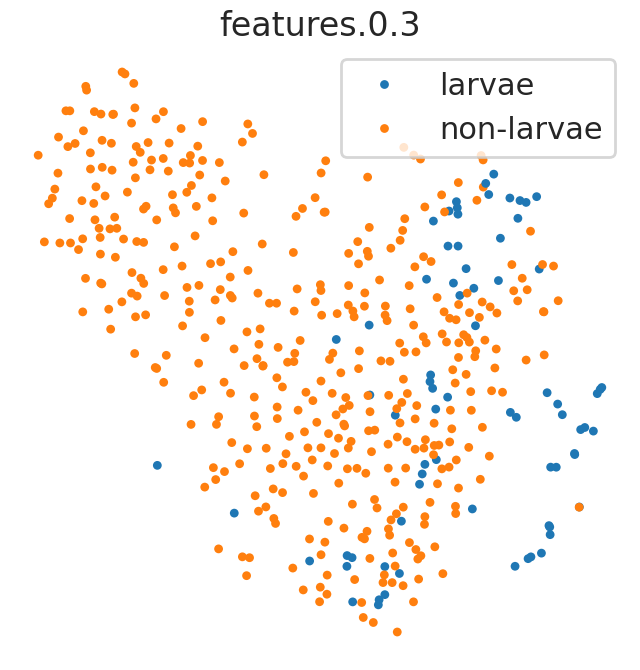

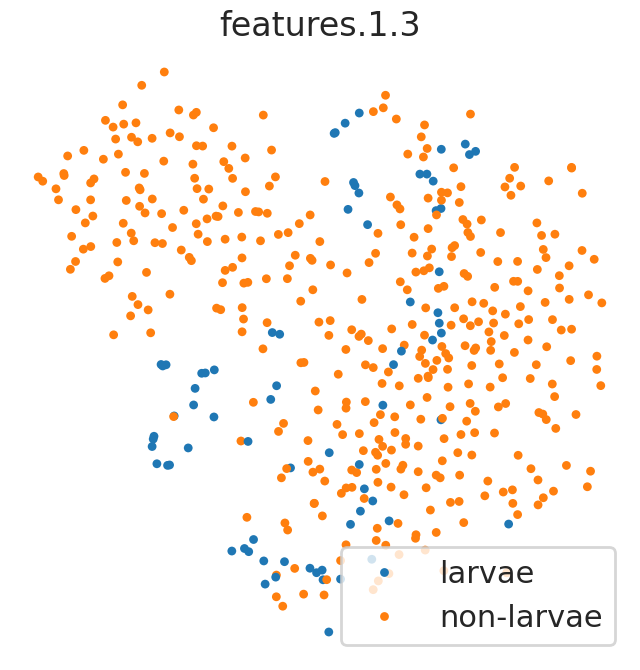

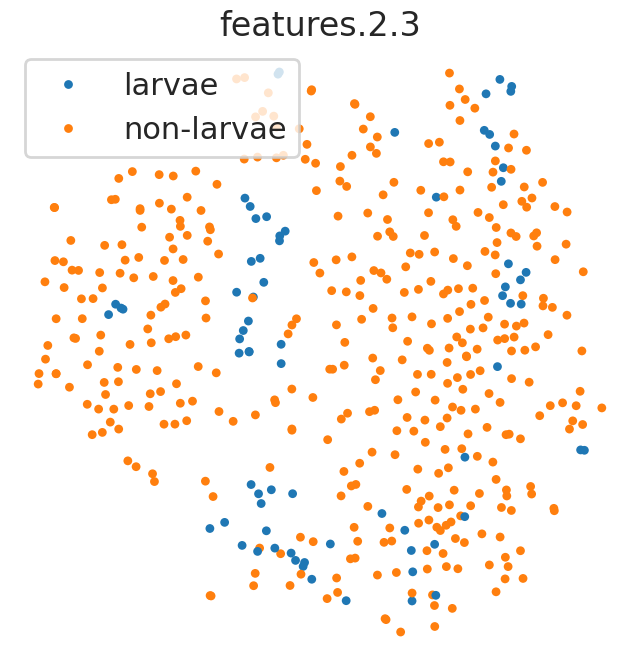

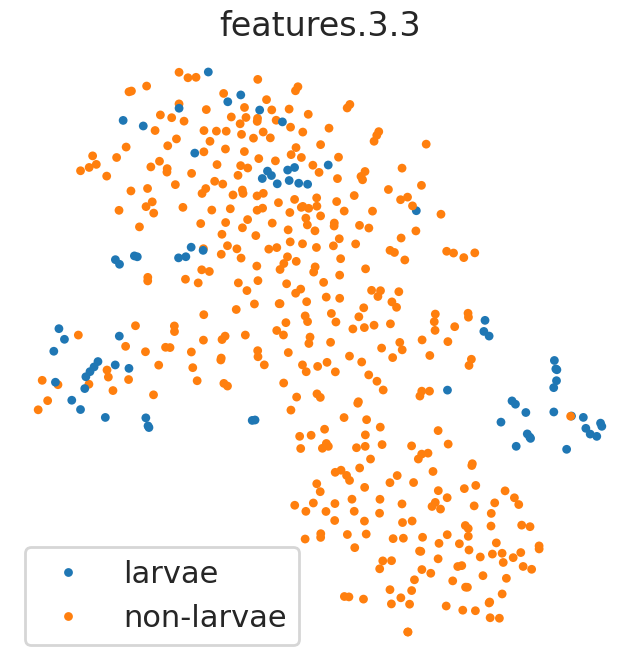

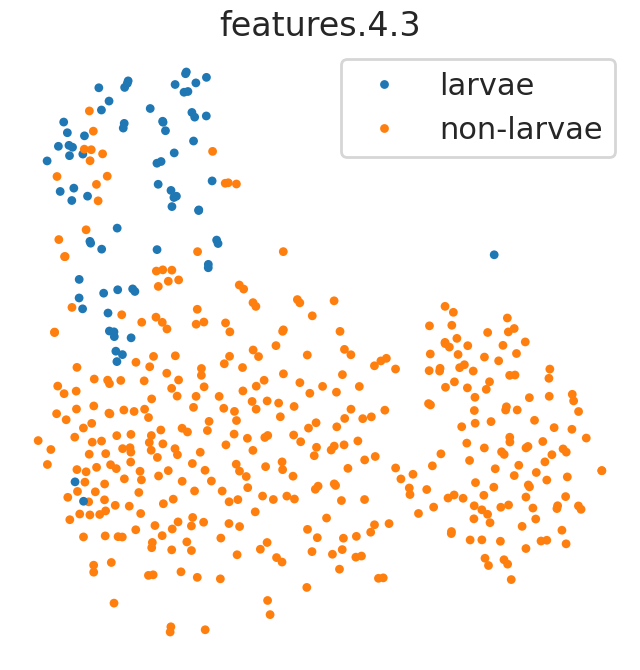

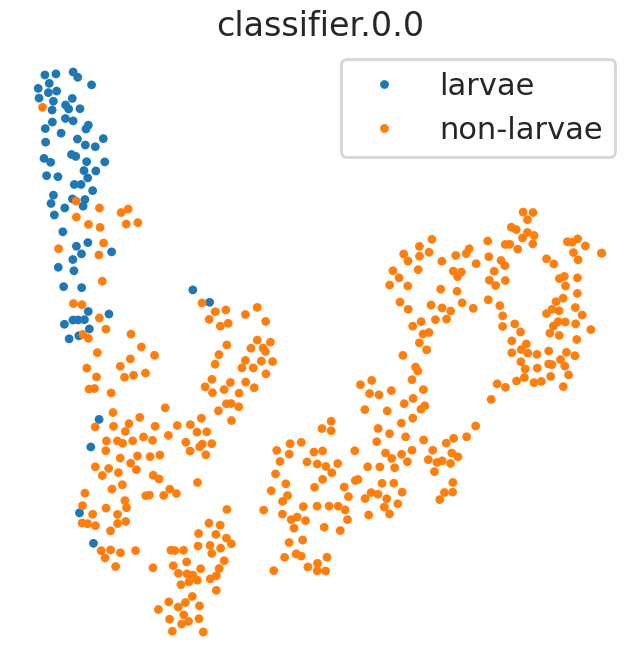

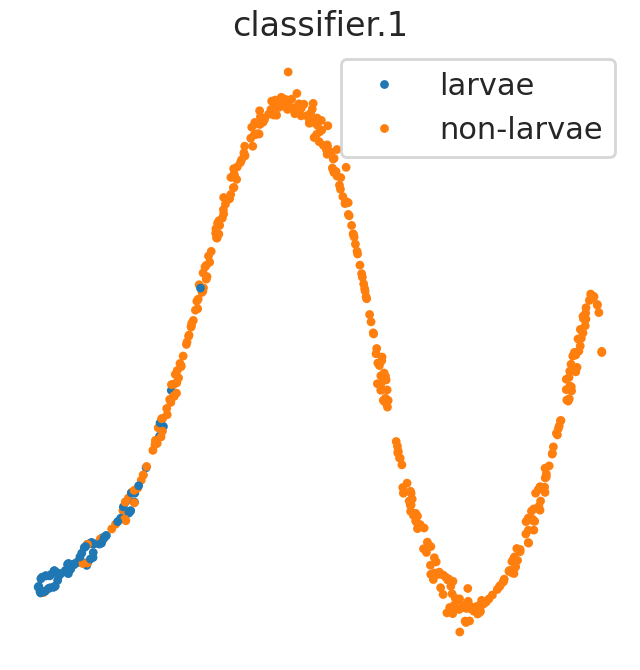

In [47]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


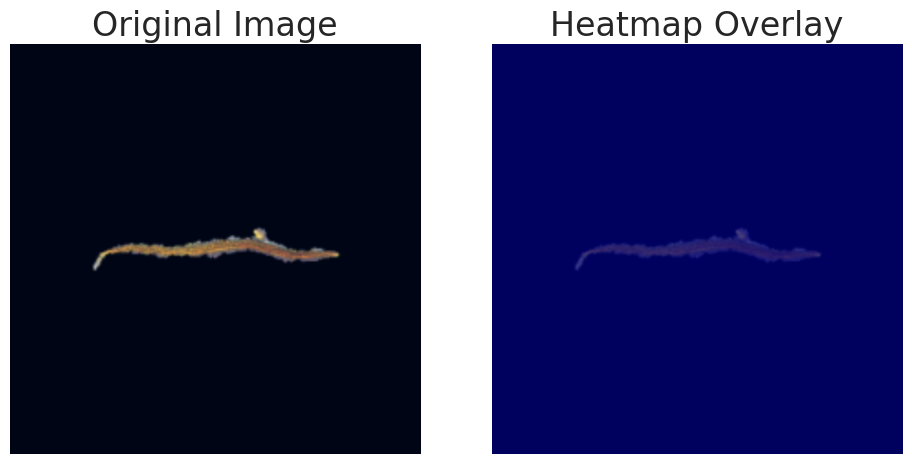

  Generating heatmap for Larvae...
  Predicted label is Larvae!


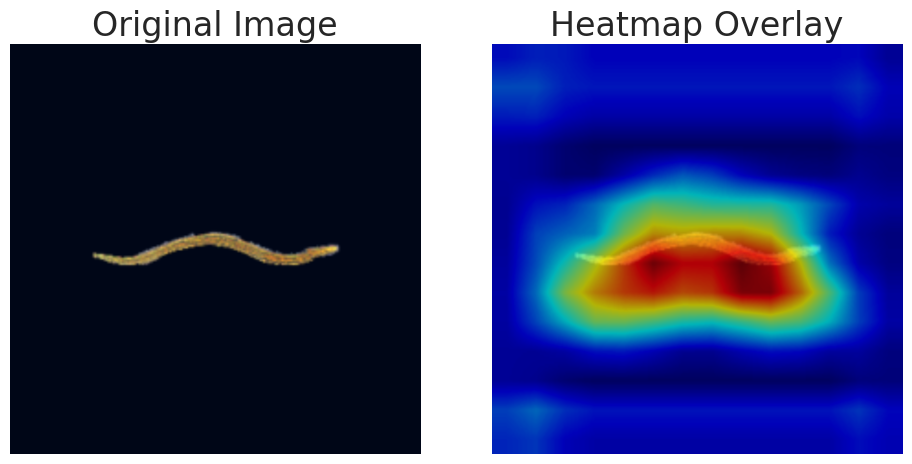

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [49]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[32,64,96,128,224],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 96, 56, 56]          55,296
      BatchNorm2d-10           [-1, 96, 56, 56]             192
             ReLU-11           [-1, 96, 56, 56]               0
        MaxPool2d-12           [-1, 96, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         110,592
      BatchNorm2d-14          [-1, 128,

In [50]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=2e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-5)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [51]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.7395 | Val Loss: 0.6917 | Train cohen_kappa_fn: 0.0146 | Val cohen_kappa_fn: 0.0191 | Train f1_fn: 0.0878 | Val f1_fn: 0.1438
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6384 | Val Loss: 0.6783 | Train cohen_kappa_fn: 0.0756 | Val cohen_kappa_fn: 0.1016 | Train f1_fn: 0.3552 | Val f1_fn: 0.4380
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5613 | Val Loss: 0.6407 | Train cohen_kappa_fn: 0.0625 | Val cohen_kappa_fn: 0.0804 | Train f1_fn: 0.3019 | Val f1_fn: 0.3587
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4531 | Val Loss: 0.5212 | Train cohen_kappa_fn: 0.3955 | Val cohen_kappa_fn: 0.4236 | Train f1_fn: 0.8458 | Val f1_fn: 0.8445
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.3779 | Val Loss: 0.4423 | Train cohen_kappa_fn: 0.3089 | Val cohen_kappa_fn: 0.2839 | Train f1_fn: 0.7514 | Val f1_fn: 0.7173
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3027 | Val Loss: 0.5944 | Train cohen_kappa_fn: 0.1142 | Val cohen_kappa_fn: 0.0885 | Train f1_fn: 0.4554 | Val f1_fn: 0.3832
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.2701 | Val Loss: 0.2563 | Train cohen_kappa_fn: 0.6972 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9410 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2075 | Val Loss: 0.8998 | Train cohen_kappa_fn: 0.0387 | Val cohen_kappa_fn: 0.0501 | Train f1_fn: 0.2072 | Val f1_fn: 0.2524
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.1829 | Val Loss: 0.2538 | Train cohen_kappa_fn: 0.4551 | Val cohen_kappa_fn: 0.6403 | Train f1_fn: 0.8442 | Val f1_fn: 0.9228
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1537 | Val Loss: 0.1994 | Train cohen_kappa_fn: 0.8001 | Val cohen_kappa_fn: 0.7901 | Train f1_fn: 0.9641 | Val f1_fn: 0.9665
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1248 | Val Loss: 0.1733 | Train cohen_kappa_fn: 0.7038 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9396 | Val f1_fn: 0.9644
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1375 | Val Loss: 0.6270 | Train cohen_kappa_fn: 0.8820 | Val cohen_kappa_fn: 0.5684 | Train f1_fn: 0.9832 | Val f1_fn: 0.9487
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1108 | Val Loss: 0.3370 | Train cohen_kappa_fn: 0.9163 | Val cohen_kappa_fn: 0.8194 | Train f1_fn: 0.9866 | Val f1_fn: 0.9745
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1107 | Val Loss: 0.1338 | Train cohen_kappa_fn: 0.7023 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9387 | Val f1_fn: 0.9641
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.0866 | Val Loss: 0.5362 | Train cohen_kappa_fn: 0.9039 | Val cohen_kappa_fn: 0.6775 | Train f1_fn: 0.9852 | Val f1_fn: 0.9589
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0897 | Val Loss: 0.2161 | Train cohen_kappa_fn: 0.7038 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9396 | Val f1_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.0862 | Val Loss: 0.5665 | Train cohen_kappa_fn: 0.9006 | Val cohen_kappa_fn: 0.6354 | Train f1_fn: 0.9853 | Val f1_fn: 0.9556
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.0765 | Val Loss: 0.1460 | Train cohen_kappa_fn: 0.5169 | Val cohen_kappa_fn: 0.7423 | Train f1_fn: 0.8741 | Val f1_fn: 0.9496
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0886 | Val Loss: 3.2564 | Train cohen_kappa_fn: 0.2134 | Val cohen_kappa_fn: 0.0333 | Train f1_fn: 0.9272 | Val f1_fn: 0.9168
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


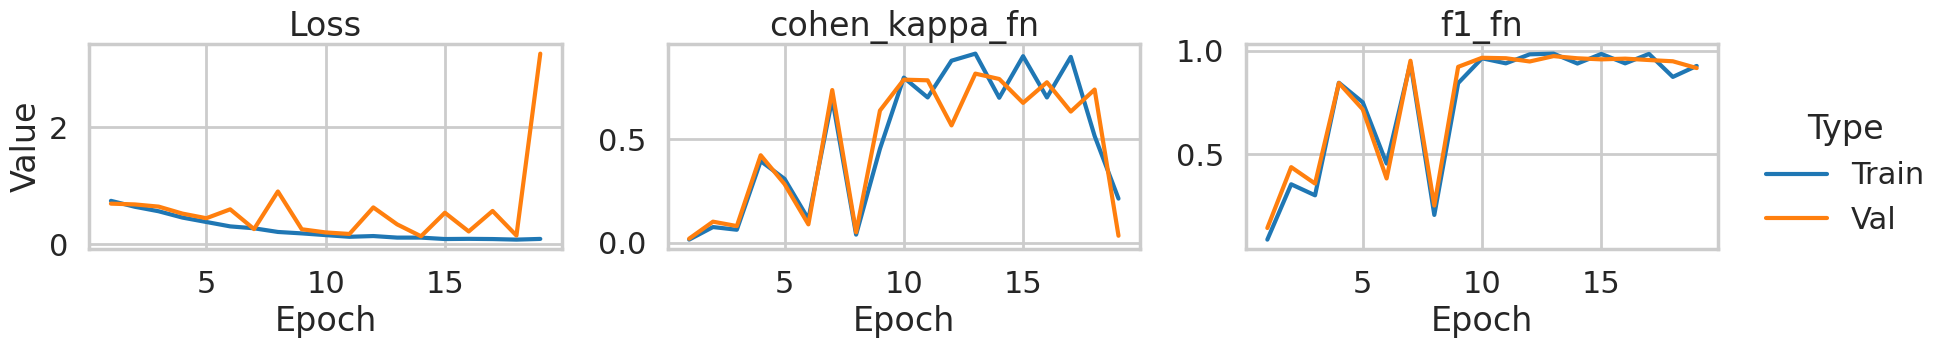

In [52]:
trainer_cnn_5.plot_epochs()

In [53]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1346 | Test cohen_kappa_fn: 0.8220 | Test f1_fn: 0.9699


#### Visualization

In [54]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

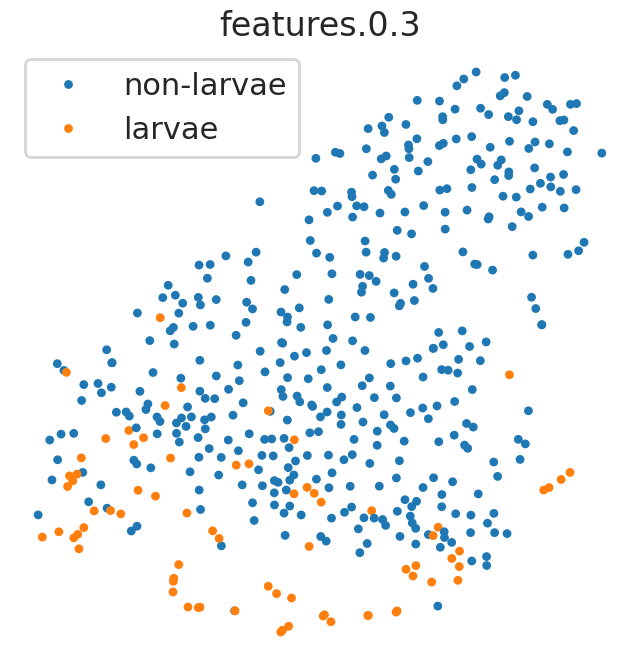

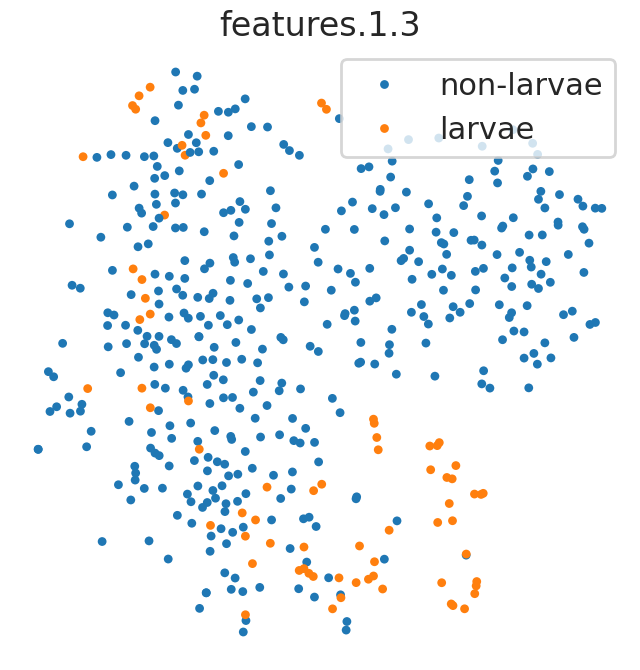

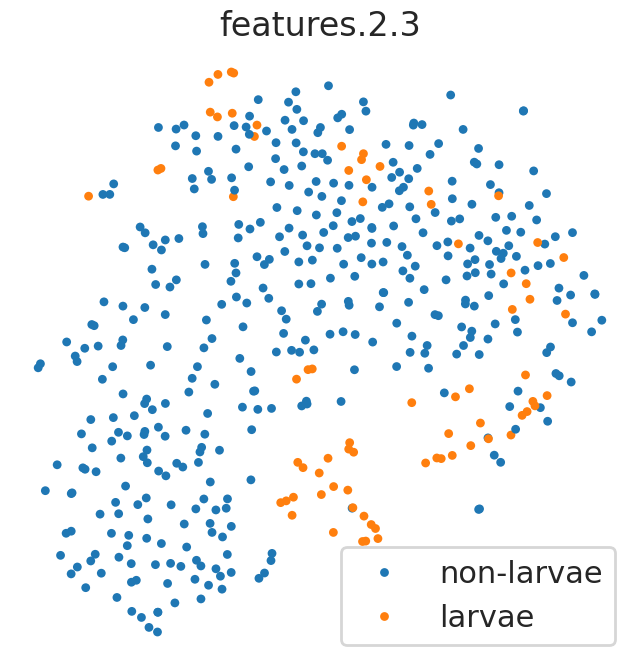

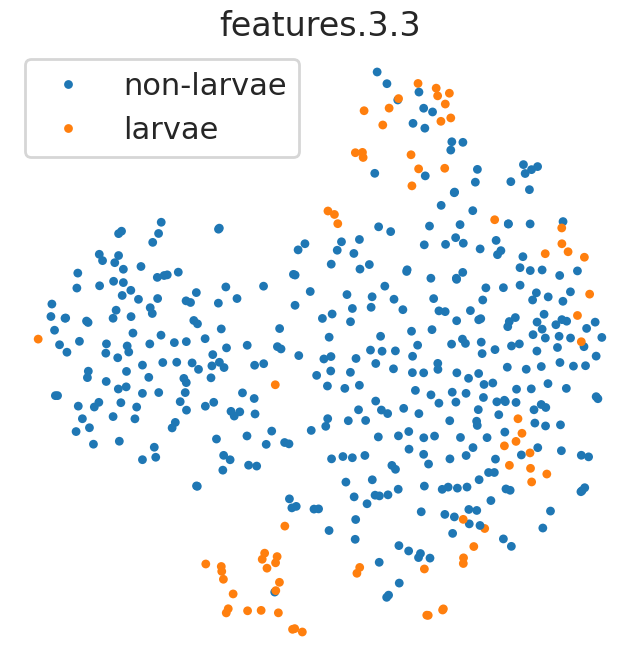

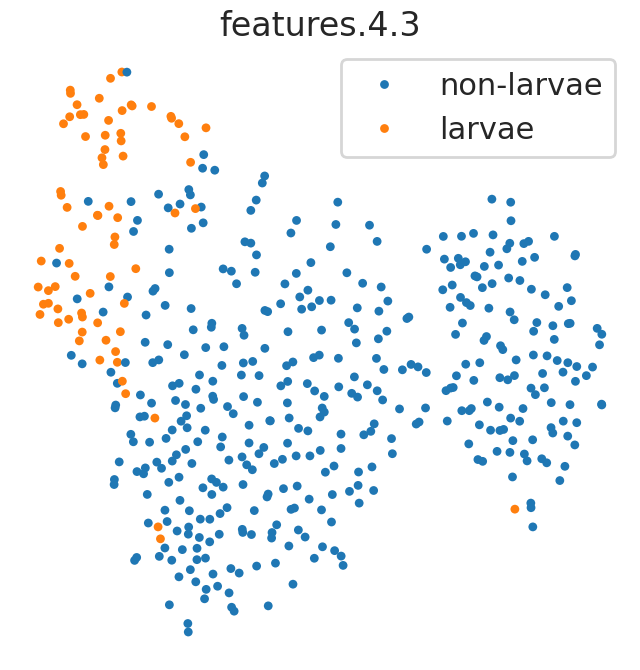

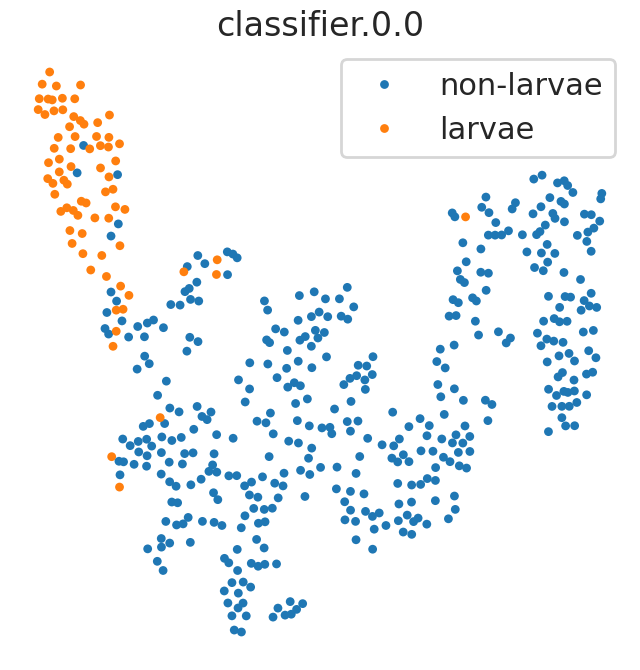

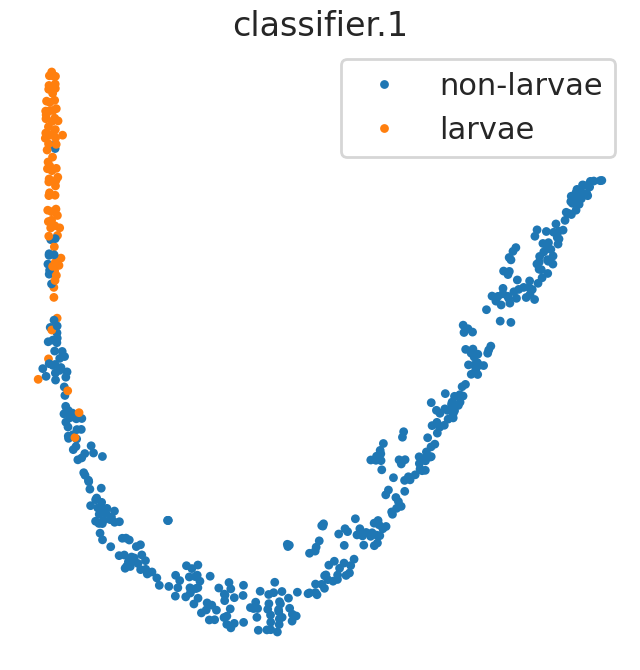

In [55]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


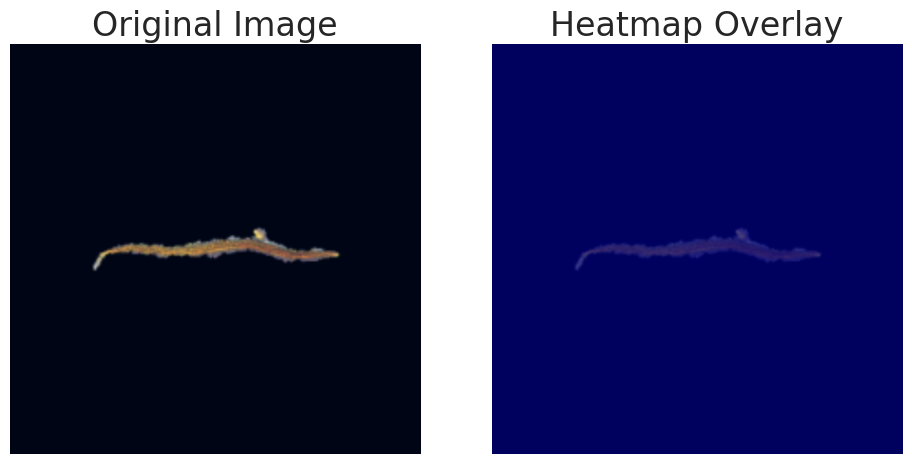

  Generating heatmap for Larvae...
  Predicted label is Larvae!


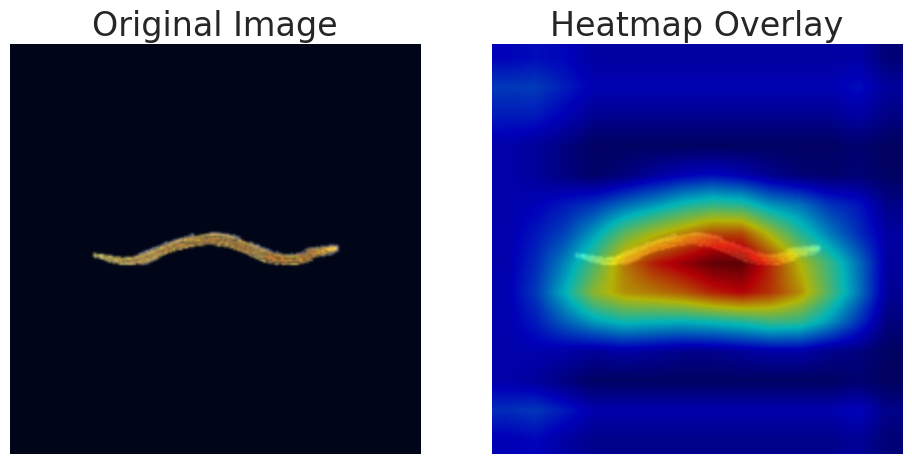

In [56]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [57]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [58]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=2e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-5)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [59]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6892 | Val Loss: 0.6905 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6249 | Val Loss: 0.6646 | Train cohen_kappa_fn: 0.0722 | Val cohen_kappa_fn: 0.0890 | Train f1_fn: 0.3354 | Val f1_fn: 0.4232
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6036 | Val Loss: 0.6397 | Train cohen_kappa_fn: 0.0619 | Val cohen_kappa_fn: 0.1109 | Train f1_fn: 0.2997 | Val f1_fn: 0.4438
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5350 | Val Loss: 0.5737 | Train cohen_kappa_fn: 0.0942 | Val cohen_kappa_fn: 0.1293 | Train f1_fn: 0.4182 | Val f1_fn: 0.4874
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5021 | Val Loss: 0.5420 | Train cohen_kappa_fn: 0.3348 | Val cohen_kappa_fn: 0.3404 | Train f1_fn: 0.8411 | Val f1_fn: 0.8821
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4863 | Val Loss: 0.4725 | Train cohen_kappa_fn: 0.2624 | Val cohen_kappa_fn: 0.2628 | Train f1_fn: 0.7104 | Val f1_fn: 0.7109
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4295 | Val Loss: 0.4176 | Train cohen_kappa_fn: 0.2881 | Val cohen_kappa_fn: 0.3269 | Train f1_fn: 0.7298 | Val f1_fn: 0.7626
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3641 | Val Loss: 0.3693 | Train cohen_kappa_fn: 0.3065 | Val cohen_kappa_fn: 0.3868 | Train f1_fn: 0.7518 | Val f1_fn: 0.8062
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3090 | Val Loss: 0.3913 | Train cohen_kappa_fn: 0.2591 | Val cohen_kappa_fn: 0.2780 | Train f1_fn: 0.7006 | Val f1_fn: 0.7187
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.3086 | Val Loss: 0.3235 | Train cohen_kappa_fn: 0.5782 | Val cohen_kappa_fn: 0.4797 | Train f1_fn: 0.9043 | Val f1_fn: 0.8649
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2769 | Val Loss: 0.3707 | Train cohen_kappa_fn: 0.5168 | Val cohen_kappa_fn: 0.3350 | Train f1_fn: 0.8763 | Val f1_fn: 0.7748
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2783 | Val Loss: 0.7781 | Train cohen_kappa_fn: 0.1486 | Val cohen_kappa_fn: 0.1055 | Train f1_fn: 0.5310 | Val f1_fn: 0.4302
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2642 | Val Loss: 0.3693 | Train cohen_kappa_fn: 0.8270 | Val cohen_kappa_fn: 0.7305 | Train f1_fn: 0.9733 | Val f1_fn: 0.9596
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2282 | Val Loss: 0.2948 | Train cohen_kappa_fn: 0.7785 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9632 | Val f1_fn: 0.9649
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1910 | Val Loss: 0.2559 | Train cohen_kappa_fn: 0.7687 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9579 | Val f1_fn: 0.9572
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.1970 | Val Loss: 0.3173 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.7288 | Train f1_fn: 0.9618 | Val f1_fn: 0.9551
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2031 | Val Loss: 0.4688 | Train cohen_kappa_fn: 0.2855 | Val cohen_kappa_fn: 0.3000 | Train f1_fn: 0.7216 | Val f1_fn: 0.7395
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1846 | Val Loss: 0.2735 | Train cohen_kappa_fn: 0.5938 | Val cohen_kappa_fn: 0.6035 | Train f1_fn: 0.9063 | Val f1_fn: 0.9149
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1643 | Val Loss: 0.2947 | Train cohen_kappa_fn: 0.5732 | Val cohen_kappa_fn: 0.5458 | Train f1_fn: 0.8971 | Val f1_fn: 0.8925
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1623 | Val Loss: 0.2930 | Train cohen_kappa_fn: 0.7417 | Val cohen_kappa_fn: 0.6739 | Train f1_fn: 0.9495 | Val f1_fn: 0.9385
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


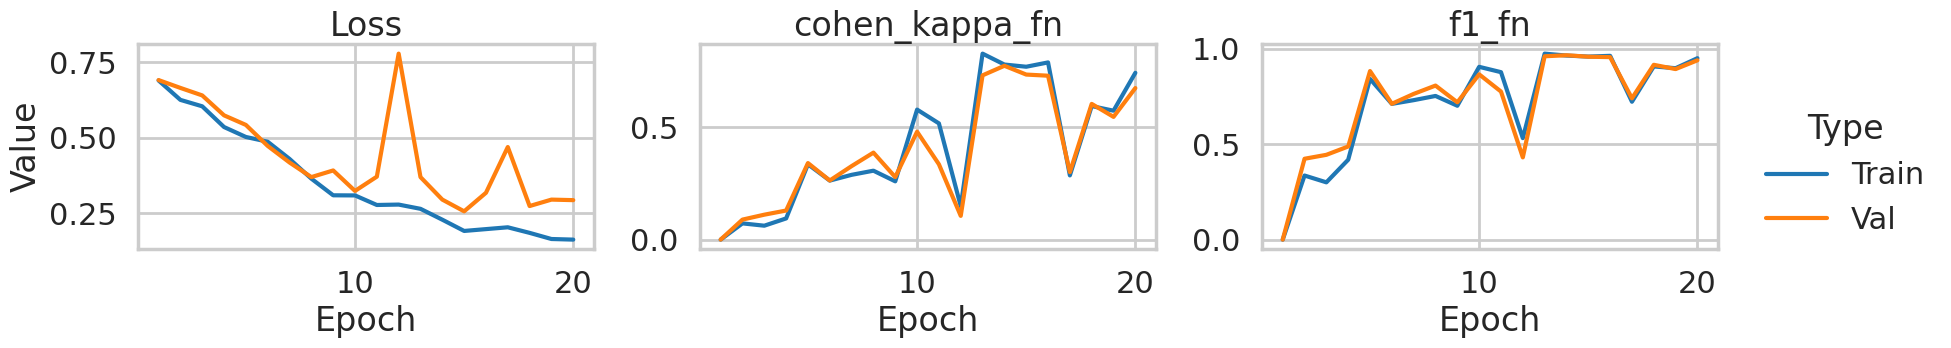

In [60]:
trainer_cnn_6.plot_epochs()

In [61]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2426 | Test cohen_kappa_fn: 0.8017 | Test f1_fn: 0.9707


#### Visualization

In [62]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

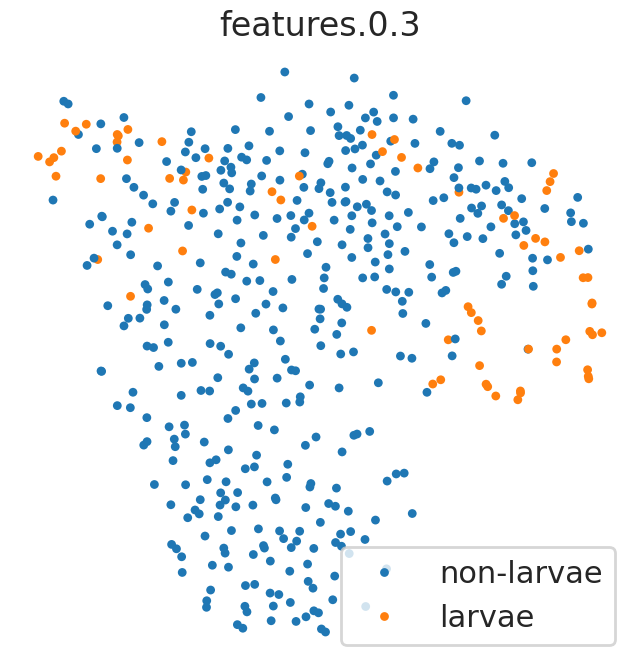

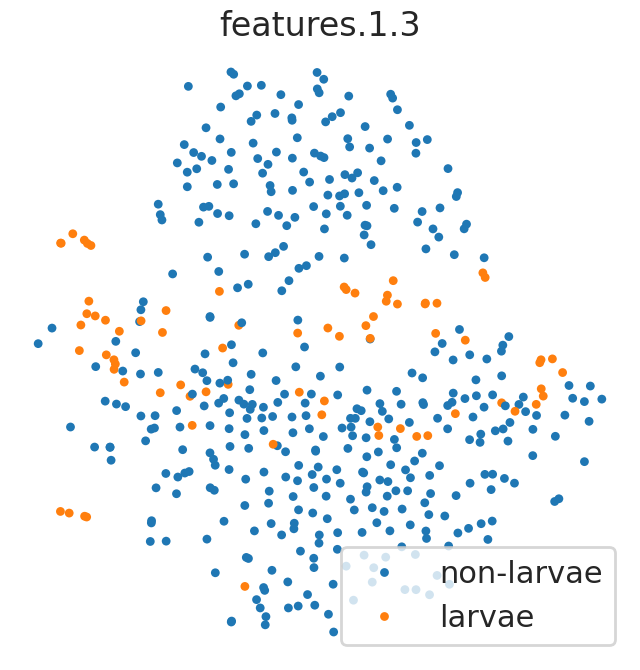

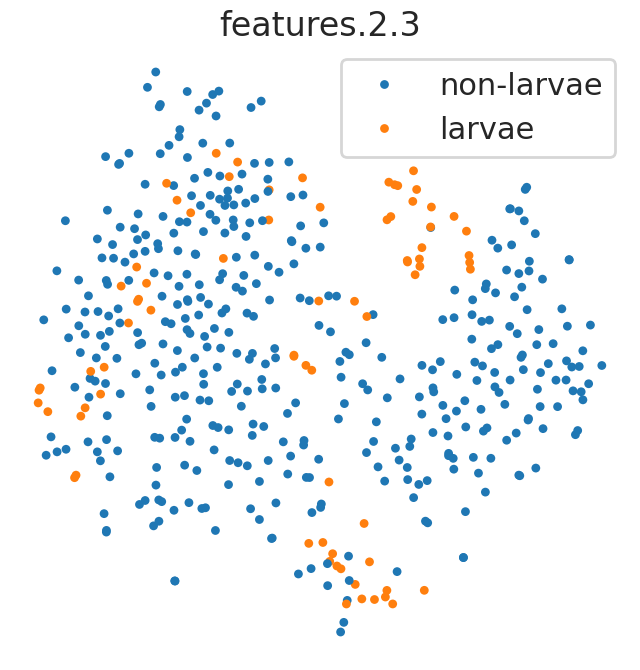

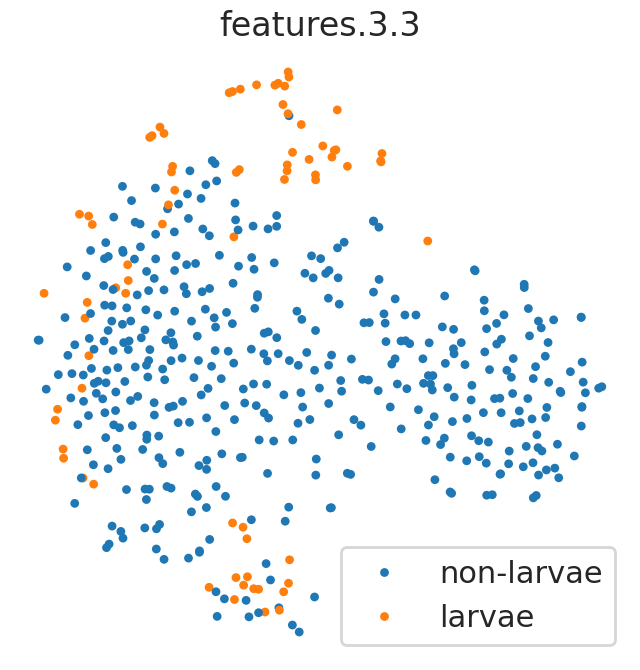

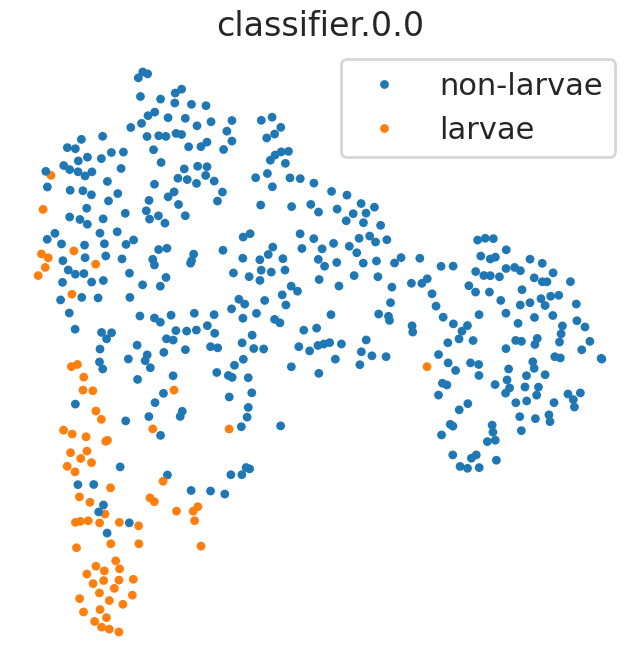

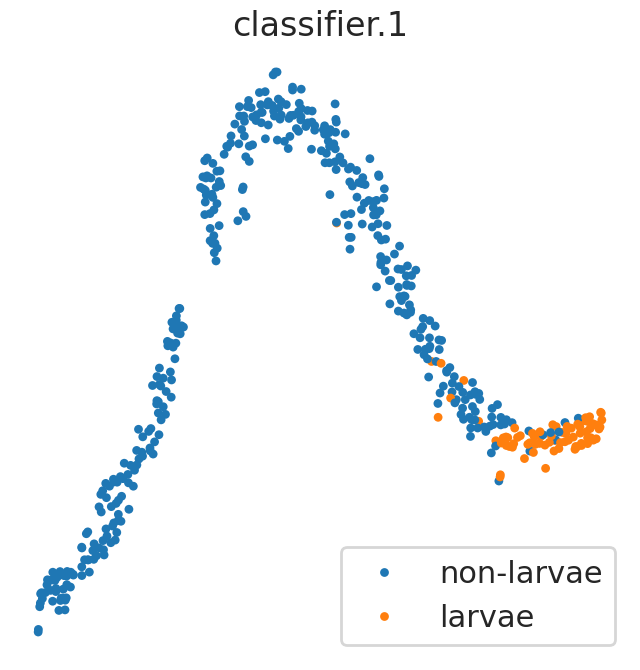

In [63]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


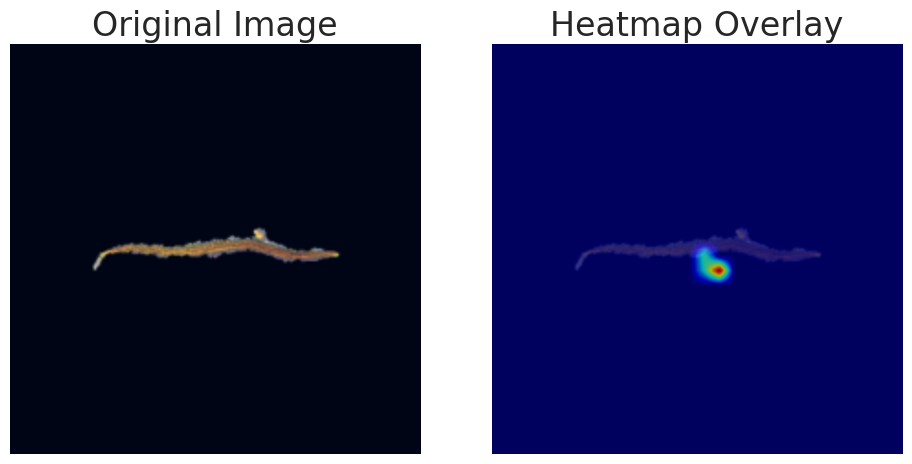

  Generating heatmap for Larvae...
  Predicted label is Larvae!


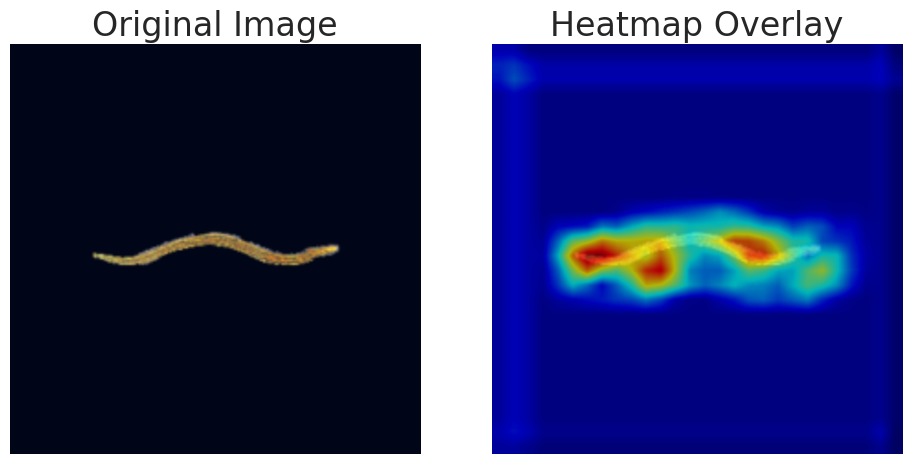

In [64]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [65]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[16,32,64,96,128,224],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             432
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,608
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,432
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          55,296
      BatchNorm2d-14           [-1, 96,

In [66]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=2e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-5)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [67]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6860 | Val Loss: 0.6919 | Train cohen_kappa_fn: 0.0750 | Val cohen_kappa_fn: 0.0831 | Train f1_fn: 0.4791 | Val f1_fn: 0.5134
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6318 | Val Loss: 0.6755 | Train cohen_kappa_fn: 0.3955 | Val cohen_kappa_fn: 0.4596 | Train f1_fn: 0.8707 | Val f1_fn: 0.8906
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5486 | Val Loss: 0.6536 | Train cohen_kappa_fn: 0.0079 | Val cohen_kappa_fn: 0.0095 | Train f1_fn: 0.0491 | Val f1_fn: 0.0576
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4464 | Val Loss: 0.5243 | Train cohen_kappa_fn: 0.2012 | Val cohen_kappa_fn: 0.1732 | Train f1_fn: 0.6246 | Val f1_fn: 0.5849
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.3478 | Val Loss: 0.4863 | Train cohen_kappa_fn: 0.2626 | Val cohen_kappa_fn: 0.2014 | Train f1_fn: 0.7043 | Val f1_fn: 0.6278
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2690 | Val Loss: 0.2776 | Train cohen_kappa_fn: 0.7618 | Val cohen_kappa_fn: 0.7021 | Train f1_fn: 0.9582 | Val f1_fn: 0.9468
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2438 | Val Loss: 0.3444 | Train cohen_kappa_fn: 0.4978 | Val cohen_kappa_fn: 0.4614 | Train f1_fn: 0.8679 | Val f1_fn: 0.8493
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.1810 | Val Loss: 0.2559 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.6453 | Train f1_fn: 0.9422 | Val f1_fn: 0.9276
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1872 | Val Loss: 0.8717 | Train cohen_kappa_fn: 0.4984 | Val cohen_kappa_fn: 0.4228 | Train f1_fn: 0.9453 | Val f1_fn: 0.9371
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1674 | Val Loss: 0.3210 | Train cohen_kappa_fn: 0.5732 | Val cohen_kappa_fn: 0.4905 | Train f1_fn: 0.8971 | Val f1_fn: 0.8667
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.1428 | Val Loss: 0.5557 | Train cohen_kappa_fn: 0.8232 | Val cohen_kappa_fn: 0.7222 | Train f1_fn: 0.9761 | Val f1_fn: 0.9642
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.1278 | Val Loss: 0.3558 | Train cohen_kappa_fn: 0.9001 | Val cohen_kappa_fn: 0.7826 | Train f1_fn: 0.9844 | Val f1_fn: 0.9690
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1053 | Val Loss: 0.2686 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8040 | Train f1_fn: 0.9835 | Val f1_fn: 0.9706
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


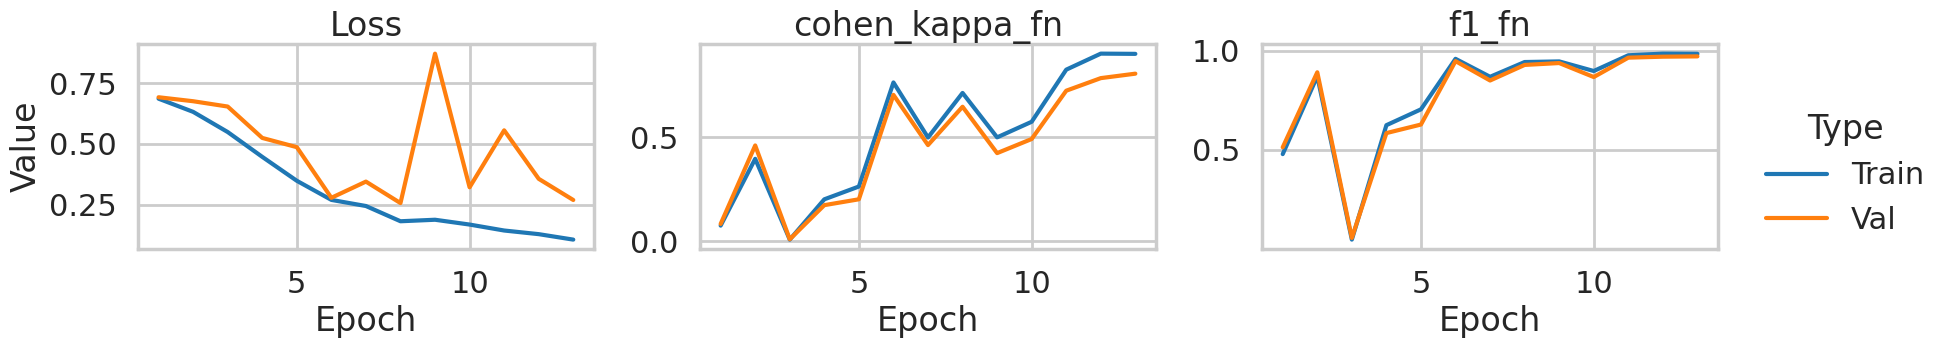

In [68]:
trainer_cnn_7.plot_epochs()

In [69]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2241 | Test cohen_kappa_fn: 0.6737 | Test f1_fn: 0.9335


#### Visualization

In [70]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

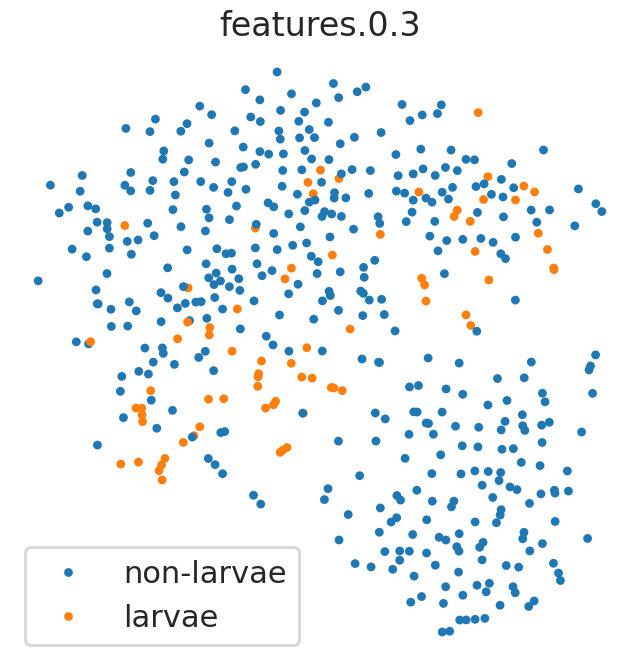

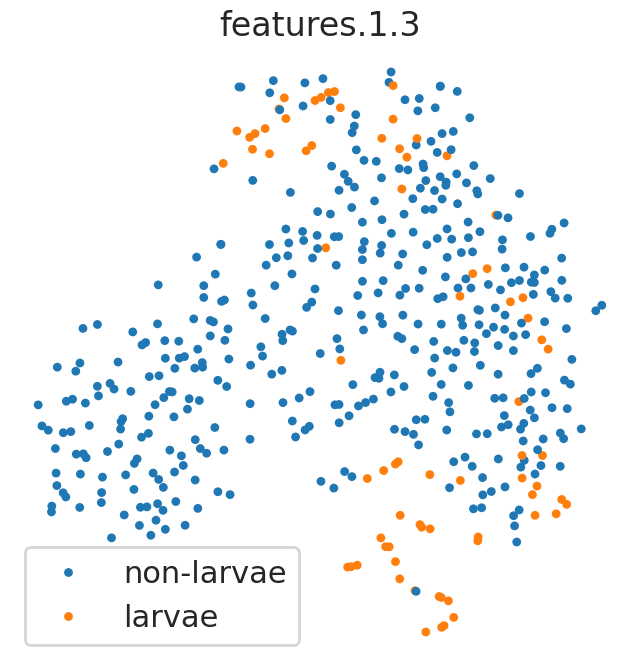

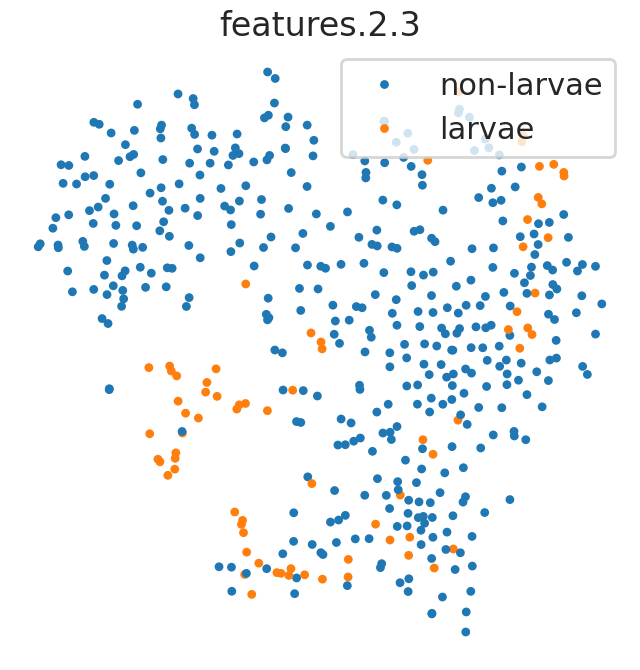

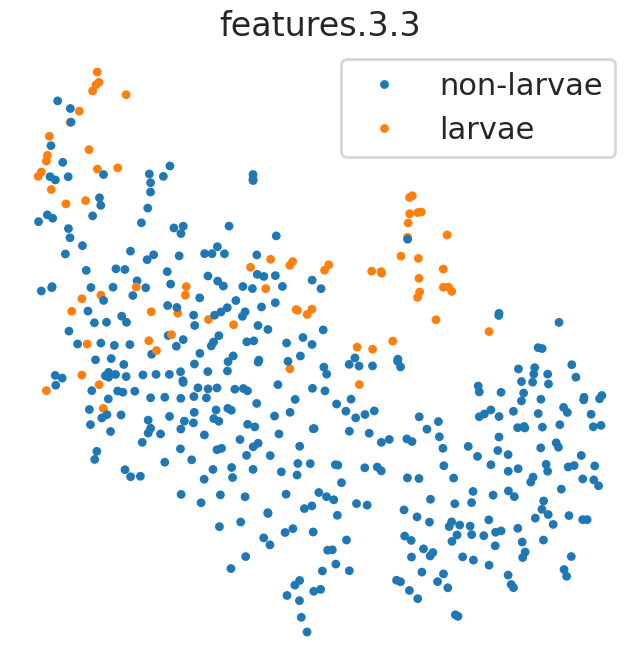

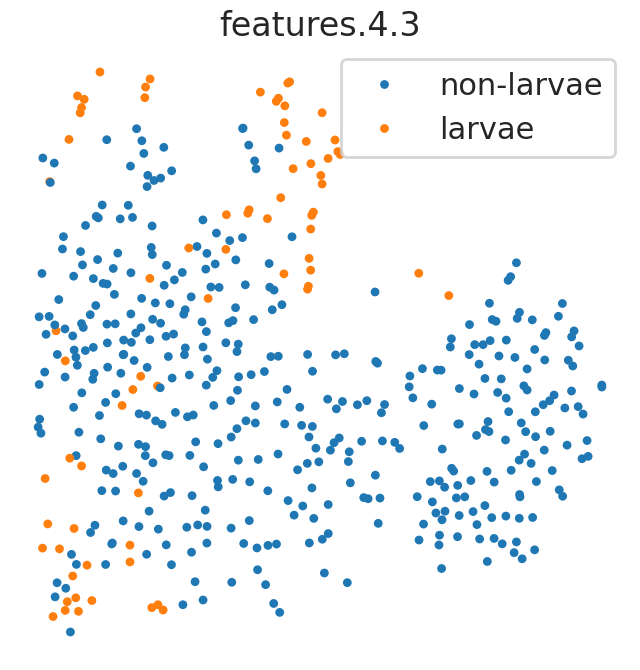

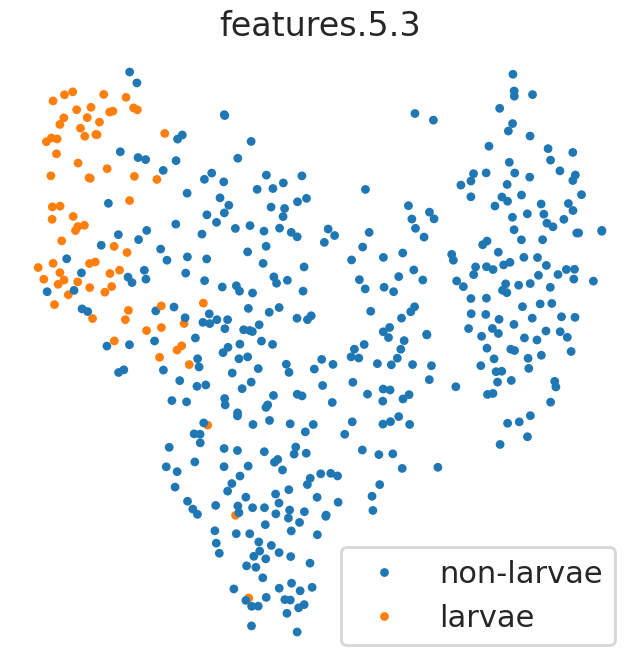

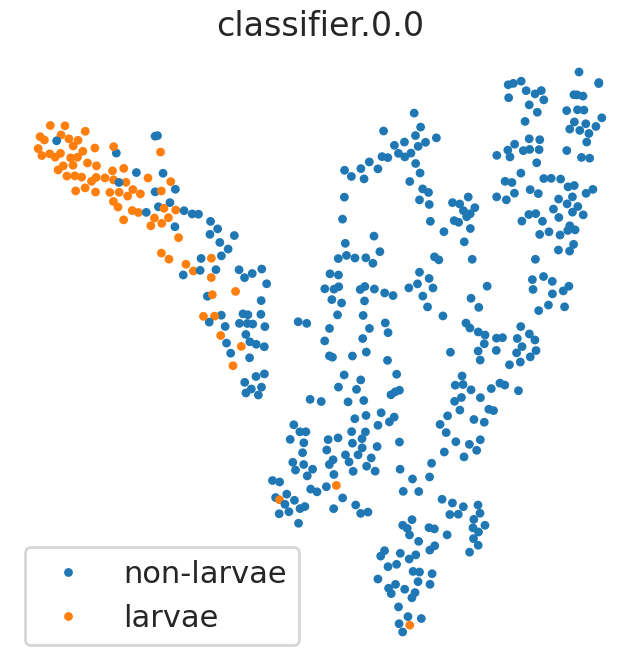

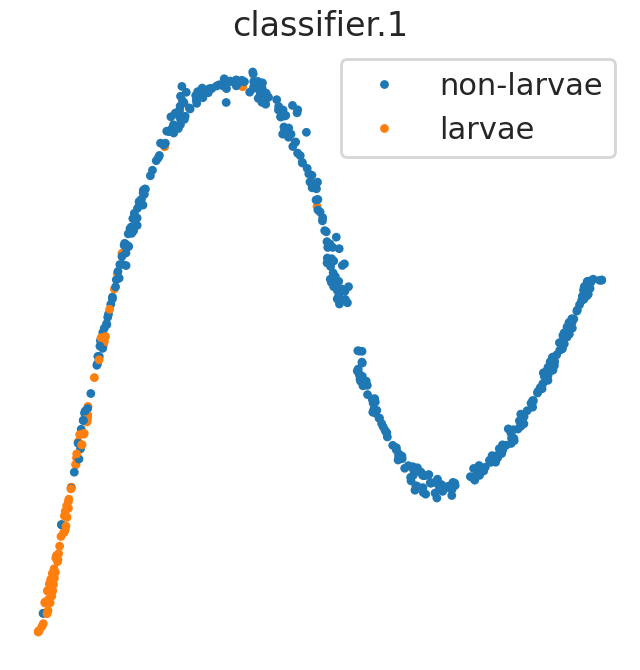

In [71]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


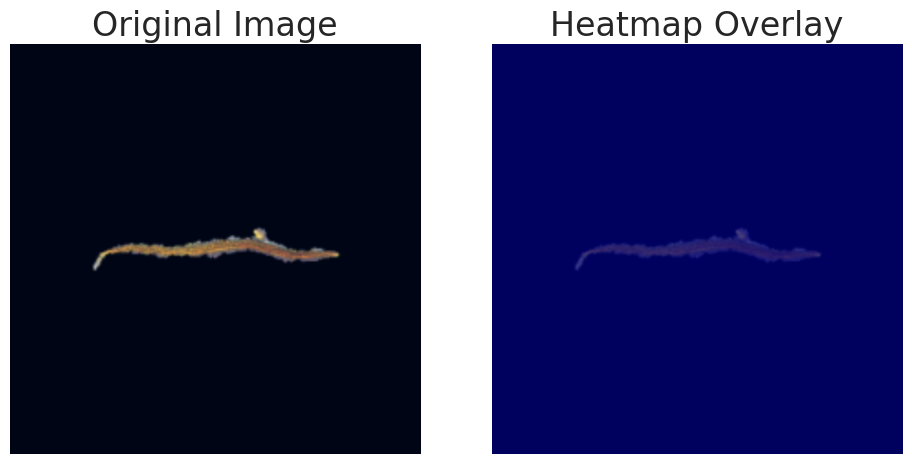

  Generating heatmap for Larvae...
  Predicted label is Larvae!


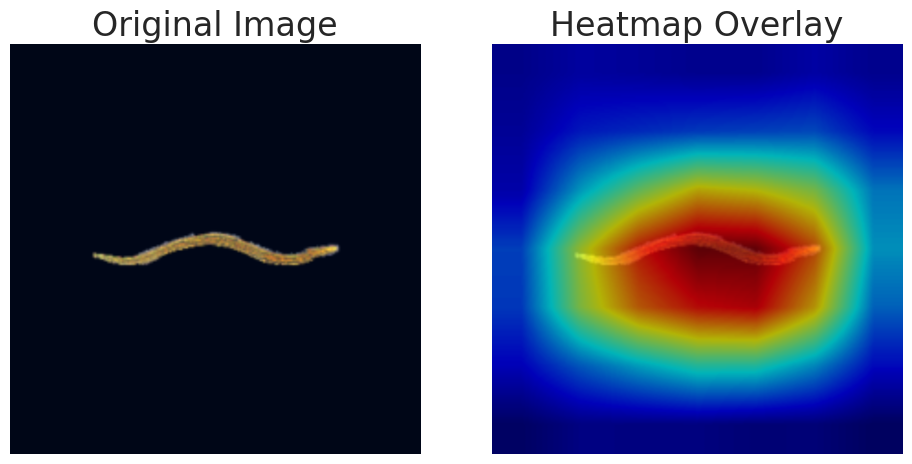

In [72]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break